In [1]:
import torch
import doubleauction

In [2]:
import torch.nn as nn

class Critic(nn.Module):
    def __init__(self, nb_states, nb_actions, hidden1=64, hidden2=64, hidden3=64):
        super(Critic, self).__init__()
        self.bn1 = nn.BatchNorm1d(nb_states)
        self.fc1 = nn.Linear(nb_states, hidden1)
        
        self.bn2 = nn.BatchNorm1d(hidden1+nb_actions)
        self.fc2 = nn.Linear(hidden1+nb_actions, hidden2)
        
        self.bn3 = nn.BatchNorm1d(hidden2)
        self.fc3 = nn.Linear(hidden2, hidden3)
        
        self.bn4 = nn.BatchNorm1d(hidden3)
        self.fc4 = nn.Linear(hidden3, 1)

        self.relu = nn.ReLU()
    
    def forward(self, s, a):
        out = self.fc1(self.bn1(s))
        out = self.relu(out)

        out = self.fc2(self.bn2(torch.cat([out,a],1)))
        out = self.relu(out)
        
        out = self.fc3(self.bn3(out))
        out = self.relu(out)
        
        out = self.fc4(self.bn4(out))
        
        return out
    
    

class Actor(nn.Module):
    def __init__(self, nb_states, nb_actions, hidden1=64, hidden2=64, init_w=3e-3):
        super(Actor, self).__init__()
        self.bn1 = nn.BatchNorm1d(nb_states)
        self.fc1 = nn.Linear(nb_states, hidden1)
        
        self.bn2 = nn.BatchNorm1d(hidden1)
        self.fc2 = nn.Linear(hidden1, hidden2)
        
        self.bn3 = nn.BatchNorm1d(hidden2)
        self.fc3 = nn.Linear(hidden2, nb_actions)
        
        self.relu = nn.ReLU()   
        self.softplus = nn.Softplus()
    
    def forward(self, x):
        out = self.fc1(self.bn1(x))
        out = self.relu(out)
        
        out = self.fc2(self.bn2(out))
        out = self.relu(out)
        out = self.fc3(self.bn3(out))
#         out = self.softplus(out)
        
        return out
    
    

In [3]:
import torch.nn as nn

class Critic(nn.Module):
    def __init__(self, nb_states, nb_actions, hidden1=64, hidden2=64, hidden3=64):
        super(Critic, self).__init__()
        self.fc1 = nn.Linear(nb_states, hidden1)
        
        self.fc2 = nn.Linear(hidden1+nb_actions, hidden2)
        
        self.fc3 = nn.Linear(hidden2, hidden3)
        self.fc4 = nn.Linear(hidden3, 1)

        self.relu = nn.ReLU()
    
    def forward(self, s, a):
        out = self.fc1(s)
        out = self.relu(out)

        out = self.fc2(torch.cat([out,a],1))
        out = self.relu(out)
        
        out = self.fc3(out)
        out = self.relu(out)
        
        out = self.fc4(out)
    
        return out
    
    

class Actor(nn.Module):
    def __init__(self, nb_states, nb_actions, hidden1=64, hidden2=64, init_w=3e-3):
        super(Actor, self).__init__()
        self.fc1 = nn.Linear(nb_states, hidden1)
        
        self.fc2 = nn.Linear(hidden1, hidden2)
        
        self.fc3 = nn.Linear(hidden2, nb_actions)
        
        self.relu = nn.ReLU()   
        self.softplus = nn.Softplus()
    
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        
        out = self.fc2(out)
        out = self.relu(out)
        out = self.fc3(out)
#         out = self.softplus(out)
        
        return out
    
    

In [4]:

import scipy.stats
import numpy as np
from doubleauction.agents import Buyer, Seller
import torch
        
class DDPGSeller(Seller):
    def __init__(self, agent_id: str,  reservation_price: float, *,
                    max_noise=50., anneal_steps=1e4, min_noise=5.,
                    batch_size = 64, mem_size=100000, lr=1e-2, width_actor=64, width_critic=64,
                    tau=1e-2, discount=0.98, wd = 1e-4):
        """
        A seller agent that extends the market agent
        :param agent_id: a unique id that differentiates this agent to other agents
        :param reservation_price: the reservation price, or minimum price that this agent is
        willing to sell
        """
        super().__init__(agent_id, reservation_price)
        self.max_noise = max_noise
        self.anneal_steps = anneal_steps
        self.min_noise = min_noise
        
        self.sigma = max_noise
        
        self.actor = Actor(5, 1, hidden1=width_actor, hidden2=width_actor)
        self.actor_target = Actor(5, 1, hidden1=width_actor, hidden2=width_actor)
        self.actor_optim  = torch.optim.Adam(self.actor.parameters(), lr=lr, weight_decay=wd)

        self.critic = Critic(5, 1, hidden1=width_critic, hidden2=width_critic)
        self.critic_target = Critic(5, 1, hidden1=width_critic, hidden2=width_critic)
        self.critic_optim  = torch.optim.Adam(self.critic.parameters(), lr=lr, weight_decay=wd)

        self.memory = SequentialMemory(limit=mem_size, window_length=1)
    
        self.tau = tau
        self.lr = lr
        self.width_actor = width_actor
        self.width_critic = width_critic

        self.mem_size = mem_size
        self.batch_size = batch_size
        
        self.discount = discount
        
        self.criterion = nn.MSELoss()
        
        self.eval = False
        
        self.game_count = 0
        
        self.new_game()
        

    
    def new_game(self):
        self.last_demand = 0
        self.game_first = True
        self.round_first = True
        self.last_successful = False
        
        self.state = None
        self.action = None
        
        self.new_round()
        
        if not self.eval:
            self.sigma = self.max_noise - self.game_count * (self.max_noise - self.min_noise) / self.anneal_steps
            self.sigma = max(self.min_noise, self.sigma)
            
        self.game_count += 1
        
    def new_round(self):
        self.round_first = True
        
        
    def decide(self, observations):
        
        ## update state
        self.state = np.array([self.last_demand, self.last_successful,
                               self.game_first, self.round_first,
                               self.reservation_price], dtype=np.float)
        s = torch.tensor(self.state).float().unsqueeze(0)

        with torch.no_grad():
            self.actor.eval()
            if self.eval:
                a = self.actor(s)
                a = a.item()
            else:
                
                n = np.random.normal(0, self.sigma)
                d = self.actor(s).item()
                a = d + n
                
#                 a = abs(a)
                print(d)
                
                
            self.actor.train()

        self.action = a
        
        self.last_demand = a
        self.game_first = False
        self.round_first = False

        return self.reservation_price + a
  

    def observe(self, reward, done):
        self.memory.append(self.state, self.action, reward, done)
        self.last_successful = (reward > 0)

        
    def learn(self):
        
        # perform grad descent    
        
        # Sample batch
        state_batch, action_batch, reward_batch, \
        next_state_batch, terminal_batch = self.memory.sample_and_split(self.batch_size)

        # Prepare for the target q batch
        with torch.no_grad():
            next_q_values = self.critic_target(
                torch.tensor(next_state_batch, dtype=torch.float),
                self.actor_target(torch.tensor(next_state_batch, dtype=torch.float)))

            target_q_batch = torch.tensor(reward_batch, dtype=torch.float) + \
                self.discount*torch.tensor(terminal_batch, dtype=torch.float)*next_q_values

        # Critic update
        self.critic.zero_grad()

        q_batch = self.critic(torch.tensor(state_batch, dtype=torch.float), 
                                torch.tensor(action_batch, dtype=torch.float))

        value_loss = self.criterion(q_batch, target_q_batch)
        value_loss.backward()
        self.critic_optim.step()

        # Actor update
        self.actor.zero_grad()

        policy_loss = -self.critic(
            torch.tensor(state_batch, dtype=torch.float),
            self.actor(torch.tensor(state_batch, dtype=torch.float)))

        policy_loss = policy_loss.mean()
        policy_loss.backward()
        self.actor_optim.step()

        # Target update
        soft_update(self.actor_target, self.actor, self.tau)
        soft_update(self.critic_target, self.critic, self.tau)
        

# Create environment

In [5]:
import matplotlib.pyplot as plt

In [6]:
import doubleauction
from doubleauction.agents import RandomSeller, RandomBuyer
from doubleauction.environments import MarketEnvironment
from doubleauction.matchers import RandomMatcher
from doubleauction.util import SequentialMemory, hard_update, soft_update
from doubleauction.util import generate_seller_prices_paper, generate_buyer_prices_paper

In [7]:
records = {}
records['rewards'] = []
records['demands'] = []
records['prices'] = []

In [8]:
rewards = []
epochs = 1000
warmup_epochs = 10
seller_agent = DDPGSeller('learner', 0, 
                          discount = 0.97, lr = 3e-4, max_noise=50., min_noise=5., anneal_steps=600,
                          wd = 1e-4, mem_size=500000, tau=5e-3)

In [9]:
%%time
for e in range(epochs):
    seller_agent.reservation_price = generate_seller_prices_paper(1)[0]
    
    sellers = []
    for ii, p in enumerate(generate_seller_prices_paper(19)):
        sellers.append(RandomSeller('s'+str(ii), p))
    sellers.append(seller_agent)

    buyers = []
    for ii, p in enumerate(generate_buyer_prices_paper(20)):
        buyers.append(RandomBuyer('b'+str(ii), p))

    agents = sellers + buyers
    
    seller_agent.new_game()
    
    setting = {
        'self_last_offer': False,
        'same_side_last_offers': False,
        'other_side_last_offers': False,
        'completed_deals': False,
        'current_time': False,
        'max_time': False,
        'n_sellers': False,
        'n_buyers': False
    }

    market_env = MarketEnvironment(sellers=sellers, buyers=buyers, max_steps=10,
                                   matcher=RandomMatcher(reward_on_reference=True), setting=setting)
    init_observation = market_env.reset()

    round_avg = 0.
    offer_avg = 0.
    time_avg = 0.
    
    records['demands'].append([])
    records['rewards'].append([])
    records['prices'].append(seller_agent.reservation_price)

    for n_round in range(10):
        
        init_observation = market_env.reset()
        observations = {k.agent_id:None for k in agents}
        done = {k.agent_id:False for k in agents}
        reward_hist = []
        rounds = 0
        terminate_round = False
        
        seller_agent.new_round()
        
        records['demands'][-1].append([])
        records['rewards'][-1].append([])
        
        offers_list = []
        
        while not terminate_round:
            offers = {}

            offers = {a.agent_id : a.decide(observations[a.agent_id]) for a in agents}

            observations, rewards, done, _ = market_env.step(offers)
            reward_hist.append(rewards)
            rounds += 1

            terminate_round = all(done.values()) or rounds >= 10 or done['learner']

            # create record of experience
            seller_agent.observe(rewards['learner'], terminate_round)
            
            offers_list.append(offers['learner'] - seller_agent.reservation_price)
            
            records['demands'][-1][-1].append(offers['learner'] - seller_agent.reservation_price)
            records['rewards'][-1][-1].append(rewards['learner'])
            
            round_avg += rewards['learner']

            time_avg += 1
    
        offer_avg += sum(offers_list) / len(offers_list)
#         time_vs_rewards.append(round_avg)
#         time_vs_demand.append(sum(offers_list) / len(offers_list))
        
        if e >= warmup_epochs:
            seller_agent.learn()
    
    print('Epoch: {}, Avg. earnings: {}, Avg. demand: {}, Avg. time: {}'.format(e, round_avg / 10., 
                                                                            offer_avg / 10.,
                                                                            time_avg / 10.))
    
    

1.9537553787231445
4.867292881011963
2.0153772830963135
0.7871166467666626
1.3647383451461792
2.1089091300964355
1.8242599964141846
1.9389654397964478
1.8571724891662598
1.6408357620239258
1.1863418817520142
Epoch: 0, Avg. earnings: -13.40142856075425, Avg. demand: -11.083985022588696, Avg. time: 1.1
2.7026526927948
6.073533058166504
1.6358129978179932
1.1184378862380981
6.8637471199035645
1.5477712154388428
3.9469587802886963
7.213589668273926
1.0364867448806763
3.709488868713379
1.1002142429351807
2.280635356903076
2.6769402027130127
3.129218578338623
5.922597885131836
6.33113956451416
2.642367362976074
3.3354506492614746
2.7364816665649414
2.1139330863952637
1.045884132385254
3.92421555519104
Epoch: 1, Avg. earnings: -32.95946903943831, Avg. demand: -3.4136369308992007, Avg. time: 2.2
2.3445310592651367
1.0938987731933594
5.747150421142578
3.9529876708984375
5.872992515563965
5.462646484375
5.781567573547363
3.911869525909424
1.5218597650527954
3.081082344055176
2.751112937927246
4.

53.8065299987793
45.81886291503906
49.97389221191406
42.22882843017578
43.43815612792969
41.93415069580078
46.12736511230469
44.0703125
48.51744842529297
Epoch: 18, Avg. earnings: -0.2874812381123192, Avg. demand: 12.083077514070357, Avg. time: 2.2
51.31249237060547
59.547672271728516
52.16440200805664
52.1119384765625
61.32674789428711
72.17378234863281
61.40928268432617
57.932071685791016
67.07022094726562
70.87818908691406
70.40174865722656
64.88082885742188
71.46357727050781
89.82415771484375
68.51171112060547
53.24005889892578
55.34503173828125
61.367706298828125
78.57270050048828
61.845542907714844
55.31243133544922
64.7940902709961
60.75956344604492
79.03006744384766
73.69786834716797
81.77332305908203
73.47980499267578
69.0029525756836
62.198486328125
65.00623321533203
55.326717376708984
66.4491958618164
71.49818420410156
56.979454040527344
57.10747146606445
76.84406280517578
68.6612319946289
66.5228500366211
64.90308380126953
73.10950469970703
67.47821044921875
66.067100524902

279.32769775390625
330.31060791015625
248.48199462890625
236.09104919433594
267.0957946777344
300.0264587402344
314.6370544433594
259.01214599609375
232.643798828125
272.1720275878906
236.8159942626953
242.00201416015625
302.03704833984375
318.28436279296875
368.4154052734375
352.4119567871094
305.0551452636719
275.646240234375
265.76580810546875
293.61102294921875
327.4585876464844
323.4696960449219
338.0891418457031
334.2311096191406
285.4401550292969
191.941162109375
146.7420196533203
172.41079711914062
255.4924774169922
289.4841613769531
316.22283935546875
313.1645202636719
292.9167785644531
272.7828063964844
267.7538757324219
235.83311462402344
227.8058319091797
226.06739807128906
199.70152282714844
243.6988983154297
197.74476623535156
163.87867736816406
148.0532989501953
231.7817840576172
315.02264404296875
285.4012756347656
237.61924743652344
261.71881103515625
313.54425048828125
368.9507141113281
336.7705078125
331.53167724609375
277.0259094238281
322.4833984375
348.73211669921

144.78102111816406
129.60781860351562
134.08837890625
205.15750122070312
175.7755126953125
147.2340087890625
192.00808715820312
152.18508911132812
161.22264099121094
174.9190216064453
172.72760009765625
170.463134765625
171.22055053710938
106.23260498046875
191.80398559570312
230.20733642578125
212.315673828125
221.6141357421875
282.8706359863281
283.7660827636719
297.5726623535156
229.190185546875
129.33592224121094
111.9930419921875
116.46027374267578
91.86163330078125
122.26241302490234
139.28343200683594
174.61708068847656
150.1987762451172
167.3166961669922
189.8577117919922
185.7924346923828
198.9380645751953
194.97027587890625
223.1459503173828
195.85708618164062
145.11158752441406
133.91229248046875
128.12725830078125
112.69109344482422
140.27401733398438
133.079833984375
127.73359680175781
151.2447967529297
140.9058837890625
194.53598022460938
171.04141235351562
119.649169921875
105.72866821289062
113.2562484741211
139.3241729736328
168.148681640625
127.97699737548828
208.9912

70.63218688964844
81.07286071777344
73.33622741699219
70.54624938964844
72.84971618652344
69.68424224853516
69.85440826416016
71.64065551757812
83.42131805419922
87.1478500366211
84.55900573730469
70.49105072021484
72.01553344726562
69.77227020263672
75.29358673095703
79.85372924804688
79.2857894897461
69.97179412841797
70.7203369140625
69.62066650390625
69.05609893798828
74.42742156982422
70.77347564697266
71.0306625366211
77.24091339111328
77.96393585205078
67.95449829101562
77.1101303100586
95.33109283447266
93.1614761352539
73.1185073852539
78.94023132324219
84.21272277832031
88.43758392333984
84.2835693359375
86.77631378173828
67.13229370117188
75.3875732421875
77.9366455078125
70.66422271728516
67.4695816040039
67.78937530517578
75.75550079345703
83.8980712890625
73.74845886230469
67.13946533203125
75.48506164550781
76.37812805175781
78.78033447265625
78.38470458984375
72.55403137207031
67.37010192871094
87.35354614257812
69.94891357421875
68.76204681396484
78.08848571777344
70.1

53.87009048461914
45.18254470825195
53.05181884765625
45.552818298339844
50.366024017333984
50.90522384643555
45.51028060913086
43.634830474853516
43.911468505859375
43.70368957519531
43.68376159667969
44.36113739013672
51.09203338623047
46.38666534423828
45.548160552978516
45.36427307128906
47.158931732177734
49.77067184448242
41.96323776245117
43.60358810424805
42.1653938293457
55.602664947509766
43.39411544799805
Epoch: 39, Avg. earnings: -2.6882316781030484, Avg. demand: 29.818601198121787, Avg. time: 2.5
53.88035583496094
54.20038604736328
49.53137969970703
64.7846450805664
50.43838119506836
51.48780059814453
51.667808532714844
50.85404968261719
49.54709243774414
57.77312469482422
49.956546783447266
49.195831298828125
49.98347091674805
51.409446716308594
49.43977355957031
51.70246505737305
48.85158157348633
51.72307586669922
57.165122985839844
49.39697265625
49.01786804199219
53.54212188720703
48.52092742919922
49.920894622802734
63.62168884277344
56.21680450439453
53.551658630371

66.88603210449219
53.89909744262695
42.775569915771484
70.30278778076172
41.7487678527832
64.38528442382812
47.854469299316406
56.962120056152344
82.4772720336914
59.87260437011719
42.00446701049805
64.13904571533203
41.50312805175781
72.6706771850586
46.39376449584961
41.8323974609375
42.883201599121094
69.91987609863281
60.37153244018555
53.553993225097656
46.22018814086914
46.50297927856445
42.05037307739258
57.629188537597656
48.6080322265625
Epoch: 48, Avg. earnings: -25.190680358648216, Avg. demand: 36.03255162264256, Avg. time: 4.3
69.42996978759766
57.15670394897461
48.68669128417969
55.9471549987793
50.26884841918945
50.44536209106445
52.372615814208984
47.528079986572266
80.00518035888672
46.2061653137207
57.51396560668945
55.13258361816406
54.87141799926758
61.886871337890625
67.63150787353516
46.344112396240234
50.510128021240234
48.057491302490234
80.12096405029297
45.81800842285156
71.8422622680664
64.95047760009766
45.5911750793457
50.078914642333984
79.03373718261719
46

33.72342300415039
43.91213607788086
80.22262573242188
41.0797233581543
42.541717529296875
83.26222229003906
33.9586067199707
35.317447662353516
74.46572875976562
66.277587890625
52.62651443481445
54.22256851196289
37.13416290283203
Epoch: 55, Avg. earnings: -18.999198487981307, Avg. demand: 53.687176510782294, Avg. time: 6.6
59.80089569091797
61.65473937988281
31.43000030517578
38.34560012817383
29.902633666992188
34.1174430847168
26.498802185058594
30.030603408813477
69.94586181640625
29.52501678466797
29.55793571472168
37.23664093017578
70.41201782226562
28.372846603393555
27.14499855041504
31.094907760620117
33.57160186767578
31.90593910217285
28.275907516479492
44.25824737548828
57.12382507324219
76.88519287109375
29.477325439453125
27.89541244506836
29.601558685302734
27.91155433654785
49.18339157104492
56.63217544555664
54.673316955566406
51.1707649230957
33.69733428955078
30.11993980407715
77.20767974853516
37.036155700683594
34.536903381347656
30.845558166503906
49.851947784423

53.14556121826172
40.33566665649414
44.84895706176758
34.117530822753906
24.679323196411133
34.87362289428711
59.23359680175781
22.998485565185547
25.8906192779541
44.772945404052734
21.346458435058594
21.789997100830078
66.23872375488281
47.36077117919922
41.311466217041016
36.96906280517578
60.81343460083008
20.97405242919922
27.015920639038086
43.46065902709961
21.596668243408203
67.78351593017578
38.60368347167969
28.65424346923828
Epoch: 65, Avg. earnings: -0.33213186095356306, Avg. demand: 34.98798869903017, Avg. time: 2.8
56.757911682128906
30.04911231994629
21.153358459472656
38.53588104248047
23.342926025390625
49.50582504272461
20.875757217407227
27.45744514465332
59.95170211791992
39.47187423706055
60.07060623168945
20.374719619750977
23.811922073364258
62.1964111328125
23.924467086791992
53.832176208496094
19.99535369873047
41.08992004394531
64.10006713867188
22.980575561523438
45.898399353027344
26.921131134033203
21.4625301361084
75.58340454101562
20.041812896728516
69.94

24.833951950073242
20.6787109375
75.11774444580078
42.8519287109375
67.5394058227539
31.670652389526367
31.612943649291992
33.093177795410156
80.09053802490234
20.9903621673584
71.38318634033203
60.525146484375
24.848209381103516
41.406429290771484
64.55215454101562
20.521387100219727
52.35358428955078
42.36009216308594
29.52672576904297
58.5155143737793
20.524372100830078
87.8471908569336
21.276521682739258
70.85820770263672
21.590862274169922
53.596309661865234
44.581626892089844
26.663860321044922
61.946414947509766
52.75663757324219
63.65614318847656
66.9964370727539
24.67983627319336
70.03656005859375
52.74955749511719
42.19184494018555
58.667903900146484
38.648101806640625
51.466697692871094
32.662437438964844
48.586158752441406
Epoch: 75, Avg. earnings: -11.980901499516463, Avg. demand: 38.26149188358711, Avg. time: 6.0
51.90049743652344
15.300222396850586
15.927202224731445
30.694887161254883
15.234611511230469
15.119770050048828
79.80088806152344
23.95867347717285
28.928888320

42.197265625
15.323029518127441
13.779793739318848
42.365234375
54.29737854003906
48.42302703857422
48.40335464477539
13.820258140563965
54.23715591430664
22.217927932739258
21.930137634277344
33.66762924194336
58.561195373535156
28.06014060974121
20.1909122467041
43.99248504638672
28.904220581054688
33.717769622802734
34.779876708984375
43.09442138671875
30.66976547241211
40.57793045043945
46.97173309326172
19.79364776611328
17.16539192199707
63.477325439453125
15.101829528808594
50.07618713378906
40.1036262512207
15.088685989379883
58.01774597167969
42.448543548583984
33.08937454223633
51.022918701171875
45.01803970336914
30.033647537231445
44.51198196411133
49.11376953125
18.210363388061523
50.420631408691406
Epoch: 85, Avg. earnings: -16.06155924861874, Avg. demand: 39.78915478096705, Avg. time: 7.1
52.44733810424805
22.651508331298828
51.08584213256836
14.583911895751953
21.811838150024414
22.152408599853516
14.528593063354492
37.79362106323242
40.852901458740234
40.33535766601562

Epoch: 95, Avg. earnings: -1.5707885150916177, Avg. demand: 23.22395931936672, Avg. time: 2.6
43.8690299987793
17.384376525878906
73.94898986816406
21.710208892822266
32.971004486083984
35.7835693359375
36.850276947021484
52.32060241699219
57.98554992675781
13.065141677856445
61.72885513305664
13.928221702575684
25.165773391723633
22.22224998474121
40.143592834472656
41.088199615478516
12.137125968933105
Epoch: 96, Avg. earnings: -14.765498472528702, Avg. demand: 8.22755402477766, Avg. time: 1.7
65.84808349609375
46.158164978027344
31.020578384399414
37.817039489746094
18.25753402709961
46.28813171386719
40.675323486328125
26.6739559173584
42.2974853515625
34.73109817504883
60.58921813964844
17.98305892944336
35.12834167480469
78.56241607666016
17.74437713623047
58.54735565185547
34.027320861816406
69.0486068725586
28.47591209411621
83.15428161621094
23.091751098632812
61.005672454833984
76.92098999023438
24.77495765686035
63.67159652709961
23.783395767211914
34.59711837768555
78.18268

29.760128021240234
46.5313835144043
25.124528884887695
58.6366081237793
16.673330307006836
Epoch: 106, Avg. earnings: 1.4286532893332207, Avg. demand: 33.195052918542146, Avg. time: 3.7
42.356563568115234
20.891624450683594
23.880367279052734
13.519229888916016
50.99015426635742
33.006385803222656
13.934473037719727
25.5439395904541
24.82186508178711
40.480194091796875
15.44739818572998
31.522430419921875
69.69086456298828
36.72858428955078
Epoch: 107, Avg. earnings: 9.287054733583314, Avg. demand: 18.562999239721087, Avg. time: 1.4
58.904754638671875
27.239431381225586
69.31836700439453
21.908906936645508
53.22978591918945
18.07699203491211
39.74920654296875
57.91813278198242
17.899831771850586
32.855628967285156
21.582590103149414
24.492877960205078
71.69083404541016
53.051265716552734
27.33861541748047
53.50349044799805
38.42157745361328
24.050046920776367
73.39608764648438
56.994384765625
51.48768615722656
51.13055419921875
31.70172691345215
18.729978561401367
43.36406707763672
75.

17.103227615356445
17.118581771850586
75.86344146728516
43.13051223754883
19.277076721191406
58.902286529541016
44.015899658203125
17.5402774810791
33.63070297241211
46.74188232421875
32.51652145385742
42.106231689453125
33.517818450927734
19.52959632873535
24.821311950683594
66.10797882080078
33.883628845214844
17.786449432373047
65.41675567626953
30.307384490966797
29.98582649230957
18.238571166992188
54.659732818603516
35.90629959106445
53.491615295410156
Epoch: 119, Avg. earnings: -27.181533131115156, Avg. demand: 31.63914874754163, Avg. time: 3.5
41.59478759765625
18.801532745361328
23.295204162597656
26.677722930908203
30.407012939453125
31.204288482666016
26.618900299072266
14.33310604095459
29.446338653564453
41.94171905517578
22.918521881103516
61.861995697021484
14.447297096252441
41.07138442993164
35.10400390625
54.56501007080078
47.03115463256836
14.147603034973145
Epoch: 120, Avg. earnings: 2.5027877826006844, Avg. demand: 16.10845825061474, Avg. time: 1.8
49.2567024230957

76.39604949951172
26.596031188964844
51.88594436645508
37.05379104614258
19.142749786376953
86.37387084960938
19.620229721069336
56.35882568359375
19.185007095336914
Epoch: 129, Avg. earnings: -26.279159452634985, Avg. demand: 29.36982983836608, Avg. time: 3.7
65.0963363647461
19.777095794677734
37.67949295043945
40.31766128540039
25.702634811401367
19.20093536376953
67.69356536865234
52.61042404174805
60.7319450378418
19.5062255859375
20.830446243286133
45.7301139831543
49.531822204589844
71.56829833984375
57.77641677856445
45.39384460449219
47.692115783691406
18.841909408569336
56.73476028442383
72.06103515625
73.32901000976562
18.85630989074707
58.433326721191406
19.316104888916016
71.99195861816406
26.82166290283203
19.597028732299805
69.53411865234375
43.4089241027832
53.48409652709961
18.89569091796875
33.814144134521484
51.04368209838867
57.01272201538086
25.63191032409668
37.26461410522461
55.0532112121582
70.23412322998047
39.234500885009766
25.607206344604492
48.3456077575683

41.53241729736328
14.200387954711914
40.027931213378906
46.966739654541016
15.35769271850586
64.17578125
13.536438941955566
46.78016662597656
30.702762603759766
Epoch: 142, Avg. earnings: 5.935402584739682, Avg. demand: 32.727155464772544, Avg. time: 1.7
64.01658630371094
17.500925064086914
20.946304321289062
17.61080551147461
83.16230773925781
17.90265464782715
63.50653076171875
50.75267028808594
36.62442398071289
68.02416229248047
17.955596923828125
22.516979217529297
44.41390609741211
41.118682861328125
84.13672637939453
17.09510612487793
81.33917236328125
49.19586181640625
17.889646530151367
48.78649139404297
16.93741226196289
17.98324203491211
58.0273323059082
17.533811569213867
67.92610168457031
35.35796356201172
17.293169021606445
68.03083801269531
47.28815841674805
61.311588287353516
20.18922233581543
33.928977966308594
27.689287185668945
52.857643127441406
19.636489868164062
43.43927764892578
18.396757125854492
64.46186828613281
36.249534606933594
55.39942169189453
64.21994018

50.362911224365234
67.4863052368164
30.880321502685547
105.78439331054688
23.265941619873047
96.50347900390625
Epoch: 151, Avg. earnings: -23.466224541595178, Avg. demand: 35.942249886987966, Avg. time: 3.9
57.14115905761719
19.858186721801758
18.373525619506836
37.629913330078125
38.02406311035156
72.51594543457031
17.40326499938965
35.89740753173828
25.4010009765625
17.487823486328125
44.5446891784668
20.346111297607422
31.352712631225586
38.284175872802734
17.332691192626953
17.099933624267578
27.355392456054688
64.83783721923828
23.443063735961914
61.90915298461914
20.81694221496582
63.191566467285156
62.14751434326172
26.074892044067383
72.05418395996094
16.068424224853516
80.98385620117188
19.22772979736328
73.73428344726562
15.376057624816895
15.789875984191895
Epoch: 152, Avg. earnings: -20.586471326635717, Avg. demand: 28.72423985657686, Avg. time: 3.1
62.44474411010742
32.7378044128418
46.27347946166992
73.34711456298828
56.592933654785156
57.69070053100586
15.946709632873535

84.5391845703125
23.901195526123047
103.40735626220703
21.905336380004883
22.133302688598633
21.968610763549805
76.53963470458984
22.353723526000977
21.79183578491211
Epoch: 160, Avg. earnings: -29.89636388820302, Avg. demand: 44.10420927269807, Avg. time: 3.6
74.82234191894531
62.19133377075195
22.835784912109375
81.78813934326172
43.67222595214844
98.87269592285156
21.217790603637695
21.220956802368164
89.28045654296875
21.150022506713867
21.183727264404297
20.86526870727539
46.80101013183594
20.851787567138672
51.775516510009766
26.791763305664062
37.27647018432617
38.5291748046875
91.47673797607422
20.82721519470215
85.01248168945312
23.601457595825195
28.31955909729004
20.649484634399414
89.8407974243164
20.420602798461914
33.063419342041016
59.871734619140625
36.51213073730469
51.22331619262695
21.07206153869629
52.61124038696289
50.81768798828125
20.381330490112305
90.10820770263672
20.730907440185547
58.62074661254883
57.17890930175781
23.525442123413086
77.36133575439453
19.60

77.0999984741211
19.57148551940918
70.71662139892578
19.563840866088867
65.29750061035156
23.868581771850586
51.08195877075195
102.21843719482422
19.126981735229492
76.94802856445312
19.397594451904297
91.94017028808594
20.292728424072266
66.85062408447266
20.037179946899414
46.455936431884766
20.13663673400879
29.056482315063477
19.64335060119629
19.39842987060547
51.927433013916016
92.7726058959961
19.40707015991211
68.72904968261719
23.654144287109375
33.544837951660156
25.713327407836914
52.661563873291016
96.22205352783203
19.693050384521484
49.19895553588867
19.59457778930664
70.55915832519531
19.63311004638672
39.55924987792969
35.36971664428711
35.63233184814453
44.007408142089844
93.1336898803711
19.002662658691406
90.48118591308594
20.755815505981445
87.88241577148438
19.496450424194336
55.154754638671875
24.669849395751953
22.384672164916992
Epoch: 169, Avg. earnings: -14.205161303091321, Avg. demand: 45.491219022884124, Avg. time: 4.7
95.04268646240234
25.450273513793945
43

64.09077453613281
17.958053588867188
17.96408462524414
17.652463912963867
18.80056381225586
66.04341888427734
18.56338882446289
85.02168273925781
17.703285217285156
57.40877151489258
56.564517974853516
29.574451446533203
18.30307960510254
50.09357833862305
17.2417049407959
59.05966567993164
101.70220947265625
15.825640678405762
27.30401611328125
34.025638580322266
68.2107162475586
28.79689598083496
79.56075286865234
16.540817260742188
17.240673065185547
15.716347694396973
94.0733642578125
16.7033634185791
48.16307067871094
72.57890319824219
20.173330307006836
Epoch: 177, Avg. earnings: 5.993664671866344, Avg. demand: 46.78956310900836, Avg. time: 3.4
84.02964782714844
15.374773979187012
91.57452392578125
15.365373611450195
63.950660705566406
20.78941535949707
101.90361022949219
15.606569290161133
104.94567108154297
38.79673385620117
16.999868392944336
106.94175720214844
17.785343170166016
93.58269500732422
19.17746353149414
16.633684158325195
52.817115783691406
34.6749153137207
44.8236

20.988645553588867
Epoch: 188, Avg. earnings: -18.41785370156834, Avg. demand: 54.43396575448596, Avg. time: 6.4
106.11300659179688
19.476598739624023
89.54217529296875
53.57064437866211
19.054000854492188
101.33174133300781
21.089740753173828
22.075618743896484
43.3002815246582
21.44010353088379
56.1069221496582
69.3360595703125
17.63544273376465
120.78436279296875
17.029067993164062
121.03788757324219
16.81328582763672
86.35749816894531
18.129594802856445
18.264039993286133
99.8446044921875
16.547224044799805
20.864290237426758
116.30058288574219
16.498865127563477
19.858905792236328
74.36882781982422
34.6371955871582
54.61960983276367
107.27406311035156
16.511871337890625
109.07170104980469
16.830921173095703
139.02362060546875
16.294048309326172
20.297767639160156
116.6287612915039
16.32718276977539
79.8534927368164
24.559616088867188
Epoch: 189, Avg. earnings: -10.461292135161775, Avg. demand: 59.041178390921935, Avg. time: 4.0
98.90406799316406
16.053386688232422
49.6682052612304

16.36387062072754
143.9844970703125
16.159271240234375
18.988317489624023
54.11342239379883
16.317296981811523
112.88716125488281
17.895326614379883
20.910341262817383
81.47789001464844
76.54155731201172
14.994927406311035
148.38894653320312
20.245101928710938
14.330183029174805
15.021810531616211
Epoch: 198, Avg. earnings: -11.764044504682804, Avg. demand: 32.947800650599376, Avg. time: 2.2
81.38594055175781
19.22812271118164
74.35045623779297
13.342019081115723
18.03534507751465
20.617942810058594
72.21044921875
91.68470764160156
12.77043342590332
64.69882202148438
15.08561897277832
56.71884536743164
15.818374633789062
95.62187957763672
14.943272590637207
31.739667892456055
15.306753158569336
100.9027328491211
31.982898712158203
54.665122985839844
100.3922348022461
16.691064834594727
16.733030319213867
Epoch: 199, Avg. earnings: -1.8233417703475623, Avg. demand: 28.874245837938183, Avg. time: 2.3
84.21766662597656
17.76028060913086
22.067180633544922
61.05538558959961
22.032407760620

125.95488739013672
16.317642211914062
61.9346809387207
22.224390029907227
45.627376556396484
21.152273178100586
93.50910186767578
15.80320930480957
91.37287139892578
27.14716339111328
106.46221923828125
15.748115539550781
115.89508819580078
14.354033470153809
35.1746940612793
14.959973335266113
93.67120361328125
15.235356330871582
69.48941040039062
16.298213958740234
Epoch: 208, Avg. earnings: -1.1410343732498334, Avg. demand: 52.45133969957847, Avg. time: 3.3
100.15985870361328
12.3624849319458
98.80937957763672
14.843130111694336
16.401851654052734
14.485858917236328
25.260570526123047
61.84668731689453
13.363986015319824
68.76285552978516
14.672286987304688
111.18968200683594
12.876138687133789
105.41285705566406
13.21208667755127
117.92558288574219
19.5633544921875
154.84478759765625
27.236495971679688
99.47505950927734
21.721410751342773
128.36611938476562
14.13558578491211
15.048587799072266
30.72553253173828
16.540733337402344
Epoch: 209, Avg. earnings: -8.204298800480661, Avg. 

111.75630950927734
17.577880859375
75.64966583251953
21.4008846282959
66.1212387084961
57.563411712646484
21.082015991210938
31.569316864013672
18.808521270751953
24.587703704833984
105.12086486816406
17.143157958984375
115.32391357421875
17.39668846130371
47.392879486083984
62.99555587768555
19.219436645507812
136.24073791503906
17.553102493286133
133.9316864013672
18.85176658630371
137.44505310058594
19.737220764160156
96.33345031738281
65.08304595947266
19.892080307006836
164.35374450683594
38.83720016479492
20.70982551574707
22.363187789916992
54.172264099121094
20.710269927978516
55.7840576171875
94.8592758178711
62.451683044433594
20.46524429321289
46.0090217590332
22.036623001098633
73.27359771728516
23.269880294799805
134.1968536376953
20.022428512573242
75.01551818847656
21.053720474243164
27.66600227355957
68.19758605957031
21.16925811767578
110.50714111328125
20.685335159301758
35.775333404541016
25.32686424255371
34.43901443481445
Epoch: 219, Avg. earnings: -13.981928166074

54.51993942260742
61.49296569824219
34.580169677734375
126.2346420288086
19.473556518554688
133.8609161376953
21.633180618286133
126.73245239257812
18.645919799804688
118.61127471923828
19.66632080078125
21.66513442993164
31.4898624420166
37.17866897583008
25.56854820251465
59.873165130615234
20.98055648803711
64.63394927978516
81.41669464111328
28.55704689025879
137.4984588623047
21.06131362915039
97.01506042480469
56.80829620361328
20.53077507019043
84.32176208496094
18.987503051757812
106.82398986816406
19.765609741210938
150.34596252441406
18.749794006347656
92.67918395996094
19.371959686279297
100.9339599609375
19.797639846801758
21.509132385253906
105.10711669921875
27.529441833496094
122.60486602783203
19.18794059753418
108.65771484375
18.055883407592773
140.35888671875
17.645349502563477
137.7855682373047
20.031681060791016
116.54949951171875
18.789409637451172
47.76952362060547
Epoch: 227, Avg. earnings: -8.272734614297416, Avg. demand: 60.26320510773129, Avg. time: 8.4
130.10

16.852079391479492
Epoch: 234, Avg. earnings: 0.4800820504841596, Avg. demand: 47.038521842505425, Avg. time: 3.2
110.96292877197266
19.347274780273438
92.72911834716797
20.326190948486328
20.76463508605957
23.18047332763672
20.038408279418945
23.56902503967285
90.77582550048828
17.74972152709961
104.27070617675781
16.540142059326172
176.86622619628906
22.349197387695312
117.65132904052734
17.678714752197266
57.32664108276367
103.50850677490234
16.42867088317871
17.86103057861328
114.94865417480469
17.403806686401367
67.98394775390625
17.431232452392578
52.736732482910156
15.868791580200195
103.61670684814453
16.84455108642578
119.158935546875
16.569284439086914
117.26770782470703
18.288583755493164
34.217018127441406
104.37956237792969
21.069665908813477
20.26333236694336
44.78437423706055
19.536602020263672
110.18412017822266
18.939451217651367
33.46827697753906
Epoch: 235, Avg. earnings: -9.240617430320523, Avg. demand: 57.075457277001604, Avg. time: 4.1
106.73221588134766
19.799245

97.76296997070312
17.12261199951172
110.75010681152344
15.960951805114746
98.77366638183594
17.21259307861328
142.92364501953125
15.449419021606445
16.827903747558594
43.743900299072266
17.729856491088867
87.21552276611328
15.253040313720703
105.6171646118164
16.574743270874023
108.49198913574219
16.022563934326172
16.65190887451172
79.62202453613281
15.229061126708984
52.036502838134766
15.06884765625
33.33076858520508
73.71726989746094
19.471771240234375
120.2752456665039
13.660021781921387
99.68560791015625
13.35123348236084
19.73387336730957
110.94393157958984
15.034407615661621
14.917214393615723
63.38098907470703
19.156352996826172
22.8509521484375
Epoch: 245, Avg. earnings: -13.476099427048263, Avg. demand: 50.47993424984965, Avg. time: 3.6
84.49758911132812
11.818586349487305
88.17765808105469
12.58976936340332
41.10934066772461
12.748658180236816
78.49945068359375
12.881178855895996
110.09022521972656
12.689810752868652
13.845277786254883
82.63191986083984
10.973209381103516
8

85.93368530273438
20.652111053466797
45.60198211669922
24.037424087524414
21.901880264282227
35.893402099609375
53.81652069091797
20.97126579284668
70.63735961914062
108.03092193603516
19.420011520385742
20.80073356628418
21.0689640045166
51.18525314331055
31.81000518798828
111.30899047851562
18.251300811767578
48.65117645263672
26.62579917907715
93.22891235351562
19.047243118286133
81.35615539550781
19.952342987060547
47.04591369628906
20.33270263671875
90.15166473388672
22.396045684814453
66.00973510742188
19.198942184448242
Epoch: 255, Avg. earnings: -4.413280583853114, Avg. demand: 42.44489279580252, Avg. time: 6.4
126.05023193359375
47.866153717041016
128.02810668945312
22.555908203125
25.132795333862305
45.366485595703125
101.02852630615234
54.106056213378906
22.688114166259766
107.1321029663086
21.369457244873047
25.269981384277344
23.42622184753418
106.56444549560547
22.002582550048828
41.818965911865234
23.835403442382812
102.06477355957031
20.865747451782227
71.63124084472656

64.52873992919922
53.122074127197266
15.523890495300293
92.58638000488281
13.788372993469238
14.846421241760254
15.84265422821045
50.19783401489258
13.668257713317871
71.29036712646484
13.632771492004395
14.88098430633545
96.81820678710938
14.040541648864746
101.03578186035156
13.00874137878418
Epoch: 265, Avg. earnings: -1.3174059793796211, Avg. demand: 34.64097641721483, Avg. time: 2.3
87.03643035888672
15.371899604797363
15.8599214553833
93.91693115234375
15.493724822998047
94.93733978271484
14.375767707824707
34.69554138183594
15.77530574798584
88.95075225830078
13.321730613708496
101.19966125488281
16.279586791992188
67.14215087890625
16.22309112548828
100.46752166748047
13.81077766418457
15.82203483581543
18.64850616455078
16.2772216796875
76.99785614013672
32.45795822143555
16.384998321533203
17.131805419921875
87.31071472167969
14.665260314941406
19.077180862426758
16.148395538330078
16.233043670654297
18.84031105041504
66.38116455078125
16.656084060668945
Epoch: 266, Avg. earn

125.61067962646484
18.07245445251465
95.7366943359375
23.63230323791504
35.82987976074219
80.74996185302734
16.64499855041504
80.17449951171875
18.189674377441406
20.372636795043945
118.31891632080078
16.785316467285156
129.2220458984375
18.229137420654297
126.97535705566406
19.562929153442383
113.67567443847656
21.082164764404297
101.765625
22.39168930053711
23.150859832763672
102.44564056396484
21.309633255004883
23.73194694519043
72.89649963378906
22.0523624420166
113.3083724975586
21.901857376098633
63.094364166259766
24.092697143554688
124.05207061767578
23.322614669799805
125.3570785522461
23.68735694885254
93.55104064941406
24.39167594909668
Epoch: 275, Avg. earnings: -10.305175943935208, Avg. demand: 55.08675473241406, Avg. time: 4.9
97.40389251708984
20.895248413085938
101.28773498535156
21.1401309967041
30.81627082824707
53.905033111572266
78.31655883789062
21.213266372680664
24.211820602416992
96.44522857666016
21.199073791503906
36.798980712890625
46.07883834838867
20.99358

119.21685791015625
18.701343536376953
106.35955047607422
19.900070190429688
161.51168823242188
17.395498275756836
132.95208740234375
17.080955505371094
114.41481018066406
17.682994842529297
107.17384338378906
19.658544540405273
61.8974494934082
18.286746978759766
35.97499465942383
74.69137573242188
20.100191116333008
67.58068084716797
18.96125030517578
110.6895751953125
17.716184616088867
85.70925903320312
19.39118766784668
63.169105529785156
70.48530578613281
19.37023162841797
76.42282104492188
19.853769302368164
128.9224395751953
18.52546501159668
143.3284149169922
19.72868537902832
150.90431213378906
21.725337982177734
119.06920623779297
21.288982391357422
52.591796875
95.71630859375
21.51238250732422
23.67917251586914
40.32665252685547
23.386125564575195
57.796058654785156
23.32892608642578
104.4277572631836
23.079303741455078
102.83668518066406
22.789051055908203
95.93683624267578
22.67704200744629
24.53162956237793
92.12120056152344
24.02167320251465
79.07744598388672
28.29049301

88.87324523925781
19.993974685668945
52.14718246459961
78.66167449951172
31.225343704223633
20.3317928314209
23.42816734313965
46.299537658691406
39.843658447265625
21.208782196044922
22.395944595336914
104.70530700683594
19.319002151489258
81.26582336425781
19.172971725463867
60.35715866088867
19.85772705078125
19.838315963745117
37.50861740112305
19.649356842041016
97.67505645751953
18.77365493774414
36.44364547729492
67.11323547363281
19.341100692749023
Epoch: 293, Avg. earnings: -4.113806708588848, Avg. demand: 48.98291589072974, Avg. time: 5.3
100.36911010742188
17.379859924316406
87.76029968261719
17.612150192260742
96.17656707763672
17.939258575439453
23.42194938659668
83.56517791748047
17.624723434448242
61.543678283691406
18.443222045898438
75.11637115478516
17.354257583618164
81.84266662597656
17.706642150878906
44.91636657714844
17.6149959564209
36.287288665771484
58.54975509643555
43.087982177734375
104.60286712646484
17.27256965637207
61.12131881713867
17.5786190032959
36.

23.31187629699707
56.69341278076172
129.771728515625
22.704397201538086
109.0196304321289
23.13675308227539
52.251365661621094
23.565540313720703
145.08567810058594
23.486751556396484
94.63438415527344
23.06844139099121
136.84808349609375
22.96782112121582
122.07075500488281
23.081045150756836
69.62075805664062
23.16357421875
23.315631866455078
23.376134872436523
25.374422073364258
23.693445205688477
100.04231262207031
23.220003128051758
Epoch: 299, Avg. earnings: -11.011055644131101, Avg. demand: 54.67716656194436, Avg. time: 6.5
99.21147155761719
20.18556022644043
74.27882385253906
20.621009826660156
108.14315795898438
19.9399356842041
20.289928436279297
73.23506927490234
20.54319953918457
20.507984161376953
80.36870574951172
20.649002075195312
49.23015213012695
20.120929718017578
101.6036376953125
20.08245849609375
65.81504821777344
20.41905403137207
119.92289733886719
19.63174819946289
22.16139030456543
58.4576416015625
19.834468841552734
112.01393127441406
19.534086227416992
28.65

58.87751770019531
22.682310104370117
23.219308853149414
122.76392364501953
21.88967514038086
134.37425231933594
21.406421661376953
54.62447738647461
22.724796295166016
121.25164794921875
22.462268829345703
154.05697631835938
20.94993782043457
104.3217544555664
33.867835998535156
54.877132415771484
22.411666870117188
96.33687591552734
21.292570114135742
Epoch: 307, Avg. earnings: -9.907652712206254, Avg. demand: 50.63294206759707, Avg. time: 6.1
126.05952453613281
22.60708236694336
25.629838943481445
118.60722351074219
22.234130859375
96.10224914550781
21.9316463470459
92.51644897460938
22.014562606811523
136.9989776611328
20.7888240814209
126.36473846435547
20.800783157348633
102.40922546386719
21.599811553955078
128.46180725097656
21.74606704711914
97.40435028076172
101.35991668701172
21.270164489746094
83.18217468261719
21.31355094909668
55.853878021240234
22.13946533203125
138.8052215576172
20.512157440185547
80.17752075195312
21.802581787109375
140.98228454589844
21.37273406982422


21.737712860107422
100.80470275878906
21.455968856811523
128.2610321044922
21.390464782714844
106.06207275390625
21.456974029541016
39.4952278137207
87.32975769042969
21.542282104492188
112.39434814453125
21.37877655029297
118.21713256835938
21.147130966186523
87.30268859863281
21.43492889404297
Epoch: 314, Avg. earnings: -13.85972463280728, Avg. demand: 45.10911034839715, Avg. time: 6.4
86.59923553466797
14.887182235717773
15.48326587677002
26.926258087158203
23.433834075927734
15.410895347595215
105.76449584960938
14.776275634765625
40.303340911865234
35.39284896850586
15.283365249633789
106.17324829101562
15.357161521911621
87.37342834472656
15.50430679321289
66.00786590576172
15.57408332824707
38.63653564453125
53.39270782470703
16.34256362915039
42.11064147949219
66.87588500976562
16.58283233642578
65.2681884765625
17.066919326782227
99.11359405517578
17.295820236206055
59.930747985839844
17.67557716369629
78.08636474609375
17.863323211669922
17.795263290405273
Epoch: 315, Avg. ea

21.211902618408203
113.41012573242188
20.63383674621582
88.576416015625
20.717666625976562
82.23786926269531
20.785472869873047
97.26634216308594
20.648677825927734
21.92420196533203
21.06203842163086
Epoch: 322, Avg. earnings: -7.0995716645398845, Avg. demand: 37.75402896522531, Avg. time: 5.7
97.16924285888672
18.289806365966797
19.39101219177246
86.93299865722656
18.375837326049805
63.61106872558594
17.755048751831055
34.04887771606445
18.041610717773438
119.86969757080078
16.853618621826172
17.428564071655273
98.80393981933594
16.824722290039062
60.387943267822266
71.24420166015625
16.66354751586914
71.18592834472656
16.360279083251953
113.43905639648438
15.188736915588379
87.46310424804688
15.685266494750977
72.37026977539062
39.45029830932617
16.32634735107422
83.88174438476562
14.83700942993164
16.043489456176758
91.70635223388672
15.331001281738281
17.23795509338379
91.69387817382812
16.10434913635254
84.10340881347656
15.665080070495605
80.67107391357422
15.964192390441895
77.

23.814905166625977
Epoch: 331, Avg. earnings: 20.512467144634478, Avg. demand: 35.76546303543072, Avg. time: 1.7
96.85697174072266
15.26511287689209
89.53919982910156
14.512679100036621
16.641237258911133
75.17945861816406
14.774126052856445
17.459314346313477
16.422250747680664
118.94764709472656
13.550915718078613
105.25533294677734
14.232285499572754
84.67018127441406
13.772605895996094
70.3945541381836
15.117448806762695
79.68136596679688
14.679161071777344
125.28716278076172
15.056351661682129
56.948707580566406
47.47776794433594
23.36359405517578
76.52836608886719
16.715923309326172
104.51512145996094
15.71975040435791
Epoch: 332, Avg. earnings: 0.964433348332107, Avg. demand: 55.96469997266653, Avg. time: 2.8
86.73979949951172
14.681644439697266
80.64812469482422
14.200398445129395
94.89045715332031
13.725922584533691
83.832275390625
14.919570922851562
40.54707336425781
16.115217208862305
15.869903564453125
60.03285217285156
16.749414443969727
57.04138946533203
16.35899925231933

80.63793182373047
14.651080131530762
95.73796081542969
15.770625114440918
91.03461456298828
30.841876983642578
16.881559371948242
95.12529754638672
15.81612777709961
16.87665557861328
17.026901245117188
88.36279296875
15.703579902648926
86.9891128540039
16.471939086914062
114.36688995361328
17.086023330688477
77.30400085449219
16.358598709106445
79.45796966552734
15.578147888183594
Epoch: 342, Avg. earnings: 3.7125244260810732, Avg. demand: 47.67257754343903, Avg. time: 2.3
104.56660461425781
16.109729766845703
81.5097427368164
15.857279777526855
34.25638198852539
76.62328338623047
15.257723808288574
96.3477783203125
15.16673469543457
74.99028015136719
15.69305419921875
89.95748138427734
14.155989646911621
96.31999969482422
13.185311317443848
90.02084350585938
13.833890914916992
106.51162719726562
14.040446281433105
78.86551666259766
13.432653427124023
60.2619743347168
13.015644073486328
110.05950927734375
11.90568733215332
56.871097564697266
35.27980422973633
53.906700134277344
13.015

19.330158233642578
139.4544219970703
19.409765243530273
37.349185943603516
56.542266845703125
122.25605773925781
20.9738826751709
97.34181213378906
22.345596313476562
144.461669921875
20.239116668701172
138.2416229248047
19.19598388671875
23.465553283691406
127.53177642822266
21.221988677978516
171.05795288085938
18.149959564208984
67.00284576416016
21.466581344604492
62.46673583984375
21.917219161987305
129.583984375
21.110158920288086
81.15973663330078
75.34082794189453
21.327917098999023
122.48197174072266
20.308652877807617
98.27723693847656
22.06293296813965
86.68011474609375
23.166446685791016
119.87970733642578
21.88639259338379
104.90826416015625
Epoch: 351, Avg. earnings: -4.80115426893164, Avg. demand: 66.30500100724338, Avg. time: 9.1
99.19861602783203
11.74881649017334
106.7242431640625
11.441405296325684
104.52491760253906
12.493037223815918
98.0352783203125
12.99380874633789
121.09069061279297
11.03197193145752
14.360560417175293
54.10673904418945
14.092894554138184
65.04

23.388065338134766
141.64759826660156
19.90414810180664
86.65999603271484
23.15867805480957
122.37066650390625
23.506547927856445
119.00399780273438
21.765478134155273
123.18024444580078
21.70100975036621
61.540401458740234
23.478971481323242
138.3911895751953
19.235200881958008
52.495819091796875
90.160400390625
25.122568130493164
39.84271240234375
111.71044921875
22.96026611328125
123.26820373535156
19.502748489379883
154.44285583496094
21.636301040649414
123.94181060791016
20.047725677490234
112.07368469238281
22.945537567138672
120.04151153564453
22.864660263061523
65.23262023925781
23.177106857299805
Epoch: 359, Avg. earnings: -7.765119184500783, Avg. demand: 61.3075053301092, Avg. time: 8.0
107.24259948730469
15.116697311401367
102.27127838134766
17.40896224975586
111.82894897460938
14.822583198547363
48.004669189453125
126.2802963256836
15.843267440795898
128.85353088378906
19.438512802124023
67.69649505615234
16.743993759155273
68.27465057373047
16.244831085205078
72.5469512939

112.41384887695312
22.82845687866211
26.867021560668945
16.672273635864258
129.563720703125
20.182453155517578
29.09150505065918
42.10065460205078
16.203805923461914
116.19657897949219
15.92983341217041
108.24665069580078
15.28542709350586
14.707931518554688
Epoch: 371, Avg. earnings: 3.2731877370644646, Avg. demand: 43.238856169133385, Avg. time: 2.0
127.14614868164062
19.175357818603516
91.4266357421875
19.6276798248291
101.26087188720703
19.613876342773438
20.125553131103516
121.55792236328125
19.193641662597656
95.33491516113281
19.385820388793945
85.44754791259766
18.668489456176758
116.40418243408203
18.06979751586914
126.09278869628906
18.054746627807617
132.1532745361328
18.32054901123047
128.97149658203125
17.313026428222656
17.945878982543945
17.94287872314453
80.12864685058594
17.345821380615234
75.29776000976562
17.78614616394043
17.899341583251953
20.57522964477539
70.34349822998047
16.530702590942383
89.11835479736328
17.00790786743164
94.17208099365234
17.12565040588379


20.657373428344727
87.9558334350586
21.23365592956543
55.01541519165039
21.007688522338867
19.714128494262695
84.99874877929688
19.896116256713867
73.6215591430664
19.917339324951172
32.988834381103516
19.897850036621094
37.769020080566406
62.70835876464844
21.45426368713379
68.86561584472656
21.702781677246094
76.96990203857422
20.78984260559082
19.691198348999023
Epoch: 381, Avg. earnings: 3.00459434257628, Avg. demand: 49.073266122061355, Avg. time: 3.2
97.08646392822266
23.36050796508789
105.2258529663086
21.49999237060547
21.561262130737305
45.48281478881836
20.828386306762695
20.823535919189453
40.34534454345703
20.90631866455078
86.83248138427734
21.891630172729492
99.0233154296875
21.47530174255371
30.026981353759766
81.48908996582031
21.459131240844727
71.19762420654297
20.432477951049805
20.44382095336914
81.66642761230469
20.58474349975586
108.68426513671875
20.981273651123047
25.03843879699707
79.0464096069336
20.6850528717041
122.28073120117188
20.91861343383789
19.5305519

18.484060287475586
94.12332153320312
18.096105575561523
82.9468994140625
18.363872528076172
91.56866455078125
18.58846664428711
80.41893005371094
18.26051902770996
110.64029693603516
18.247276306152344
18.42254638671875
107.2015151977539
18.32957649230957
107.99665069580078
17.781827926635742
102.84432220458984
18.816370010375977
18.917240142822266
42.52299880981445
18.796302795410156
37.3226432800293
Epoch: 390, Avg. earnings: 0.6537454851094424, Avg. demand: 48.492825354676555, Avg. time: 3.3
82.26416778564453
16.011411666870117
61.49077606201172
16.30769920349121
27.485382080078125
45.27947998046875
16.294851303100586
60.81642532348633
16.377029418945312
16.388011932373047
18.734304428100586
66.82781982421875
16.34737777709961
16.186994552612305
88.09840393066406
15.975772857666016
91.61104583740234
15.608040809631348
51.23328399658203
Epoch: 391, Avg. earnings: 12.625991397070745, Avg. demand: 33.30769465675662, Avg. time: 1.9
120.12071228027344
22.682106018066406
103.3821792602539

21.53589630126953
63.48031234741211
21.32861328125
106.4389877319336
21.368669509887695
120.79107666015625
21.272186279296875
54.030033111572266
20.871213912963867
84.95496368408203
21.42238998413086
50.99795150756836
21.433931350708008
20.725149154663086
114.60591888427734
20.36723518371582
80.4297866821289
20.638181686401367
61.21884536743164
20.631181716918945
47.68888854980469
19.953479766845703
106.17230987548828
19.07980728149414
19.57758903503418
66.96459197998047
19.589942932128906
64.57485961914062
19.563100814819336
125.64359283447266
19.615196228027344
19.260066986083984
Epoch: 400, Avg. earnings: -2.4808566101074563, Avg. demand: 42.119037616866606, Avg. time: 4.3
84.95396423339844
16.03307342529297
107.92231750488281
14.626014709472656
28.067171096801758
15.340161323547363
74.39971160888672
15.156981468200684
84.92330169677734
14.057708740234375
20.363481521606445
73.33831787109375
15.17711353302002
15.17291259765625
118.28564453125
14.998945236206055
27.5228328704834
29.3

133.85841369628906
23.010313034057617
146.2708740234375
21.59158706665039
127.05110931396484
22.096593856811523
21.31694793701172
70.8837661743164
22.81204605102539
140.98922729492188
21.406694412231445
21.402645111083984
117.51171112060547
21.846887588500977
62.215965270996094
21.74200439453125
20.670141220092773
121.30345916748047
21.870752334594727
20.144044876098633
47.552894592285156
111.0497055053711
21.26127815246582
20.150699615478516
117.86937713623047
21.421138763427734
20.17121696472168
106.3793716430664
21.355710983276367
140.60171508789062
20.267797470092773
106.74851989746094
20.05402183532715
126.4103775024414
19.94581413269043
126.21061706542969
19.776884078979492
124.59136962890625
20.106792449951172
94.43649291992188
20.943422317504883
24.026962280273438
100.74116516113281
20.396432876586914
90.72235107421875
20.903772354125977
65.78770446777344
19.833078384399414
46.48603439331055
19.725481033325195
29.313711166381836
19.992645263671875
52.67355728149414
19.988882064

92.14682006835938
15.647822380065918
14.753897666931152
64.6082763671875
15.977981567382812
63.850921630859375
16.091703414916992
20.94097137451172
60.54690933227539
15.647448539733887
110.51260375976562
15.292550086975098
120.37721252441406
14.194025993347168
16.942718505859375
46.450748443603516
Epoch: 417, Avg. earnings: 11.870889032651126, Avg. demand: 40.25491792875057, Avg. time: 1.9
105.35057830810547
14.57547378540039
95.32147979736328
14.745088577270508
104.05035400390625
14.431044578552246
72.7258529663086
14.989712715148926
84.84766387939453
14.729771614074707
15.107416152954102
65.16558074951172
15.832178115844727
29.549942016601562
74.2944564819336
16.28764533996582
131.80360412597656
16.07526969909668
57.481910705566406
15.495014190673828
18.78125
16.240020751953125
15.831518173217773
Epoch: 418, Avg. earnings: 10.558720087523557, Avg. demand: 48.75277110771892, Avg. time: 2.3
107.18293762207031
15.740547180175781
126.78739929199219
15.354447364807129
92.82190704345703
15

47.45790100097656
98.16378784179688
23.393571853637695
89.79972076416016
22.825315475463867
52.50114440917969
22.04279899597168
27.733415603637695
104.29515075683594
22.561878204345703
118.72073364257812
22.39779281616211
21.896028518676758
74.55484008789062
21.94135856628418
102.68190002441406
23.308115005493164
143.0253143310547
22.188570022583008
87.4323501586914
23.323387145996094
116.00552368164062
22.59758186340332
113.83409881591797
23.307445526123047
106.03431701660156
22.981491088867188
55.239898681640625
22.345294952392578
56.891937255859375
22.451391220092773
126.4427261352539
21.972244262695312
22.57649803161621
92.13851165771484
23.131315231323242
117.17658233642578
21.67896270751953
101.82035064697266
23.286914825439453
109.81291961669922
22.997695922851562
91.60172271728516
22.805389404296875
127.86383819580078
22.383420944213867
102.32955169677734
22.318368911743164
37.225128173828125
89.15959930419922
23.036211013793945
Epoch: 426, Avg. earnings: -4.273158668017326, Av

80.2159194946289
25.87066650390625
25.51480484008789
29.674482345581055
67.97317504882812
26.56761932373047
95.67559814453125
26.646574020385742
130.9322967529297
25.71114158630371
24.92832374572754
120.80319213867188
25.82370376586914
129.90431213378906
25.675256729125977
115.75337219238281
25.938692092895508
117.76344299316406
25.438735961914062
134.88165283203125
25.727819442749023
131.75938415527344
24.330568313598633
31.172266006469727
23.83164405822754
108.96563720703125
25.301753997802734
23.807781219482422
38.770057678222656
111.83421325683594
24.113828659057617
113.39802551269531
23.99551010131836
23.937204360961914
133.75074768066406
23.87033462524414
103.73379516601562
23.695932388305664
23.675060272216797
91.05606842041016
23.884817123413086
115.50027465820312
23.27954864501953
110.59134674072266
Epoch: 433, Avg. earnings: -3.360898506884999, Avg. demand: 55.30955904201776, Avg. time: 7.4
114.66344451904297
21.38117218017578
110.9079360961914
20.238759994506836
96.049751281

145.513916015625
23.342660903930664
143.7910919189453
23.614208221435547
69.12096405029297
24.38053321838379
41.20269012451172
24.079923629760742
53.12485885620117
24.346355438232422
24.06325912475586
92.11768341064453
25.287525177001953
81.97517395019531
25.165691375732422
140.0106201171875
24.013673782348633
142.31155395507812
24.256181716918945
Epoch: 442, Avg. earnings: -2.654311101253853, Avg. demand: 60.313034493971216, Avg. time: 9.4
165.9788818359375
26.91704750061035
143.1979522705078
26.757869720458984
162.6930694580078
26.82292938232422
27.30171012878418
124.94379425048828
27.659042358398438
150.8583221435547
27.260215759277344
49.795955657958984
34.19581985473633
98.69572448730469
28.542102813720703
118.50335693359375
28.509592056274414
147.55194091796875
27.65066146850586
84.20909881591797
27.854812622070312
71.75423431396484
28.552806854248047
151.26614379882812
27.292118072509766
104.34523010253906
28.72262954711914
28.810678482055664
151.80496215820312
27.33479118347168

129.7894744873047
19.089982986450195
121.78002166748047
19.127777099609375
91.32086181640625
18.4321346282959
104.35701751708984
18.236412048339844
106.52798461914062
16.962989807128906
126.56903839111328
17.52852439880371
Epoch: 450, Avg. earnings: 11.078638839398788, Avg. demand: 63.940123066456806, Avg. time: 2.5
168.65130615234375
19.89309310913086
171.70396423339844
18.882280349731445
163.1083526611328
18.918092727661133
165.98471069335938
18.916501998901367
142.67764282226562
20.15045738220215
60.46540069580078
20.37042999267578
112.85344696044922
20.589597702026367
92.67646026611328
20.432748794555664
163.8947296142578
18.658226013183594
99.3152084350586
20.120378494262695
158.04525756835938
19.487524032592773
165.03628540039062
19.584138870239258
164.68043518066406
18.167438507080078
162.69119262695312
18.25324821472168
158.5439453125
18.116186141967773
166.1420440673828
19.57820701599121
89.47029876708984
19.551469802856445
154.7088623046875
17.982200622558594
172.004943847656

92.24589538574219
18.15553855895996
147.46939086914062
18.167482376098633
118.2658920288086
18.902015686035156
155.20550537109375
17.651355743408203
151.72694396972656
17.6916446685791
Epoch: 458, Avg. earnings: 1.0370583699924267, Avg. demand: 67.37587914159292, Avg. time: 5.8
178.0340576171875
21.100553512573242
73.39781951904297
22.25273895263672
68.35153198242188
22.5107479095459
65.284423828125
57.56474304199219
102.33271789550781
22.131103515625
101.08119201660156
23.305326461791992
169.7288360595703
21.60737419128418
176.92735290527344
22.391225814819336
118.53642272949219
23.378787994384766
64.95883178710938
22.626075744628906
162.59349060058594
21.36969757080078
142.6657257080078
22.28093910217285
23.259214401245117
86.94657135009766
23.35177993774414
103.32857513427734
22.320110321044922
175.08547973632812
21.481016159057617
55.95115280151367
23.178159713745117
171.87925720214844
21.432283401489258
83.34686279296875
22.83783721923828
151.1444549560547
21.504817962646484
127.2

140.7467498779297
16.789531707763672
44.73773193359375
20.207170486450195
123.6966552734375
17.681015014648438
20.028539657592773
94.5478515625
20.034521102905273
137.38352966308594
17.204519271850586
20.23048973083496
127.0969009399414
16.894670486450195
20.040727615356445
102.53936767578125
17.26124382019043
140.2828369140625
16.94439125061035
105.310546875
17.983806610107422
41.05227279663086
20.045381546020508
113.84846496582031
17.454389572143555
161.72848510742188
16.53005027770996
48.864410400390625
19.986501693725586
146.77157592773438
16.45351219177246
159.81614685058594
17.142358779907227
128.4345245361328
16.64431381225586
149.14169311523438
17.10026741027832
130.1050262451172
16.60647964477539
148.15866088867188
16.99009132385254
149.0316925048828
16.863548278808594
156.1611785888672
16.354238510131836
19.400114059448242
33.196475982666016
19.34092140197754
59.838809967041016
19.108734130859375
Epoch: 464, Avg. earnings: -3.287742426333611, Avg. demand: 66.4024426614034, Av

89.7530746459961
16.833908081054688
147.03512573242188
16.123676300048828
144.93678283691406
15.816283226013184
146.9611053466797
15.813752174377441
130.12391662597656
15.514378547668457
24.12336540222168
Epoch: 470, Avg. earnings: -2.998644339814514, Avg. demand: 67.67552043328615, Avg. time: 5.4
165.53302001953125
17.60727882385254
20.766971588134766
163.69908142089844
18.094234466552734
103.10032653808594
21.299617767333984
130.6981201171875
17.5310001373291
95.51484680175781
21.0202693939209
20.900421142578125
111.59284973144531
19.035003662109375
164.4176483154297
17.339698791503906
162.8511199951172
17.597869873046875
162.86175537109375
17.298267364501953
108.99285125732422
19.754777908325195
20.650711059570312
35.615116119384766
77.26349639892578
20.732065200805664
161.71170043945312
17.358322143554688
106.04342651367188
20.537761688232422
33.74110412597656
66.7519302368164
20.730615615844727
163.67465209960938
17.763240814208984
159.86289978027344
17.47526741027832
161.26205444

21.315351486206055
56.01321029663086
22.068696975708008
66.51536560058594
21.39441680908203
132.58912658691406
21.295188903808594
137.404296875
21.23253631591797
104.38652038574219
21.434534072875977
65.4834976196289
22.097694396972656
83.76864624023438
22.492788314819336
139.78268432617188
20.83399200439453
142.80697631835938
20.558820724487305
47.334320068359375
21.056976318359375
144.47557067871094
22.035839080810547
143.92343139648438
21.77214241027832
19.56242561340332
137.43055725097656
19.473072052001953
143.93309020996094
18.875442504882812
116.13272857666016
19.72481346130371
98.48435974121094
19.1751766204834
Epoch: 477, Avg. earnings: 3.327749665888952, Avg. demand: 67.08763199340194, Avg. time: 5.1
174.9845733642578
23.706491470336914
157.77401733398438
23.05265235900879
167.95648193359375
22.691862106323242
180.38653564453125
24.105241775512695
179.98324584960938
22.54772186279297
172.13983154296875
24.10348129272461
179.70516967773438
23.727277755737305
180.43264770507812

153.4408416748047
18.461105346679688
127.9161148071289
19.757722854614258
159.1427459716797
18.732816696166992
166.36026000976562
20.104236602783203
Epoch: 483, Avg. earnings: -1.5815797718738722, Avg. demand: 81.40937045420209, Avg. time: 7.3
138.37698364257812
16.500478744506836
134.40185546875
17.262102127075195
146.4682159423828
16.775951385498047
137.80337524414062
17.602615356445312
130.0311737060547
16.823915481567383
135.908447265625
16.421451568603516
139.63308715820312
17.172861099243164
149.4718017578125
16.349618911743164
138.68194580078125
16.97118377685547
135.71681213378906
15.22150707244873
117.43582153320312
18.96133041381836
145.0757598876953
14.966161727905273
Epoch: 484, Avg. earnings: 9.969663806769452, Avg. demand: 72.74846649626551, Avg. time: 2.4
159.1259307861328
18.73072052001953
150.69468688964844
19.830078125
159.14715576171875
20.06061363220215
170.23922729492188
19.285057067871094
183.540283203125
19.76402473449707
181.87277221679688
18.954425811767578
141

164.6808319091797
17.382017135620117
169.900146484375
16.744274139404297
163.26390075683594
16.806352615356445
163.9786834716797
16.654443740844727
150.33953857421875
15.953001022338867
138.85079956054688
16.949602127075195
168.17788696289062
16.944774627685547
179.0452880859375
16.40428352355957
160.83761596679688
16.170772552490234
156.25811767578125
16.369665145874023
161.02609252929688
16.40707778930664
175.5746307373047
16.28471565246582
178.1994171142578
16.655237197875977
170.66969299316406
15.839498519897461
146.41448974609375
16.42142105102539
178.9552001953125
16.960681915283203
180.02093505859375
17.79608726501465
177.81829833984375
17.585887908935547
171.637939453125
16.77867317199707
179.89886474609375
17.666309356689453
180.88937377929688
18.63863182067871
164.91360473632812
18.321504592895508
167.85789489746094
19.17577362060547
180.72108459472656
20.346120834350586
181.66619873046875
18.338245391845703
182.65357971191406
19.1185359954834
156.6293182373047
19.53995132446

90.87535858154297
16.027008056640625
134.3106689453125
16.314430236816406
124.12956237792969
17.543535232543945
136.74366760253906
16.94470977783203
146.87869262695312
18.268028259277344
142.5624237060547
18.116708755493164
Epoch: 496, Avg. earnings: 13.730310339847515, Avg. demand: 69.29888773352096, Avg. time: 3.0
152.4739532470703
21.69705581665039
170.19627380371094
21.275203704833984
180.26348876953125
24.16021728515625
182.03639221191406
22.226299285888672
177.9261932373047
21.543277740478516
181.93154907226562
24.061931610107422
182.12942504882812
22.567840576171875
174.85157775878906
22.189279556274414
181.3662567138672
22.907299041748047
169.82003784179688
24.405031204223633
181.56692504882812
23.97976303100586
168.21212768554688
23.672975540161133
172.4169464111328
21.24455451965332
57.30824661254883
20.466049194335938
179.98947143554688
25.34363555908203
170.16064453125
22.021028518676758
152.845947265625
20.13286781311035
156.1984405517578
20.1528377532959
171.2489013671875

154.7979736328125
19.452211380004883
164.92884826660156
20.83381462097168
144.56561279296875
19.487817764282227
169.85597229003906
19.413524627685547
149.4585418701172
19.478858947753906
151.79811096191406
19.93284797668457
145.3883056640625
20.158262252807617
171.28900146484375
20.682544708251953
138.59127807617188
19.49997329711914
153.6617889404297
19.787302017211914
172.3134765625
21.31325912475586
Epoch: 502, Avg. earnings: -0.006970347938202792, Avg. demand: 86.2907054255143, Avg. time: 6.6
150.2755889892578
22.098600387573242
161.26051330566406
21.435739517211914
170.1848602294922
22.359766006469727
171.5307159423828
20.82438850402832
172.44268798828125
20.392230987548828
147.9160614013672
20.684677124023438
29.926881790161133
175.87770080566406
23.046154022216797
174.693115234375
22.089475631713867
173.83798217773438
22.177169799804688
161.41525268554688
21.28809928894043
169.17572021484375
23.039073944091797
155.97561645507812
22.201446533203125
154.20404052734375
21.409059524

19.70391082763672
149.1084442138672
21.038463592529297
150.27301025390625
21.114906311035156
156.07049560546875
22.301605224609375
162.1265411376953
25.483423233032227
147.90081787109375
21.2572078704834
104.86626434326172
19.695241928100586
158.333251953125
23.912952423095703
158.05458068847656
22.926132202148438
161.9176025390625
23.02796745300293
Epoch: 508, Avg. earnings: 7.858904114304634, Avg. demand: 83.65084350588327, Avg. time: 7.8
130.45095825195312
19.282316207885742
122.48360443115234
18.460458755493164
142.09732055664062
21.023454666137695
148.41790771484375
23.089431762695312
152.3035888671875
20.981719970703125
149.6547088623047
20.36856460571289
152.07070922851562
22.217681884765625
147.03424072265625
21.28557586669922
145.60269165039062
21.570741653442383
151.46885681152344
21.23673439025879
124.33269500732422
20.013750076293945
152.48313903808594
22.60797691345215
142.25030517578125
22.1531925201416
127.89659881591797
22.61081886291504
134.32852172851562
23.4825229644

170.2860107421875
28.996849060058594
162.08120727539062
27.791385650634766
161.87049865722656
28.061321258544922
166.33966064453125
25.456748962402344
161.7872772216797
24.623825073242188
162.10638427734375
25.627532958984375
153.42381286621094
24.90477752685547
149.38719177246094
24.43775177001953
156.77662658691406
25.052040100097656
162.8741455078125
24.836158752441406
166.33193969726562
24.999143600463867
124.94527435302734
22.77289581298828
168.07354736328125
25.332754135131836
166.96835327148438
26.22644805908203
171.2237548828125
25.4815616607666
169.2212677001953
25.311002731323242
169.31214904785156
25.015413284301758
169.57432556152344
24.353229522705078
167.13035583496094
25.807527542114258
168.60035705566406
24.051599502563477
152.95999145507812
23.158523559570312
168.90460205078125
24.576122283935547
33.748199462890625
172.07699584960938
26.320466995239258
172.3020782470703
22.95146942138672
170.64157104492188
23.483562469482422
157.34814453125
22.578929901123047
164.98841

25.710086822509766
159.11746215820312
26.600357055664062
159.18722534179688
28.083370208740234
139.59336853027344
24.756507873535156
154.70632934570312
28.234027862548828
160.48916625976562
27.579633712768555
148.52525329589844
26.3070011138916
105.92391967773438
24.625383377075195
155.00790405273438
28.161701202392578
148.19662475585938
27.56060028076172
158.2545166015625
27.05613899230957
64.70344543457031
23.36250877380371
160.91004943847656
27.421287536621094
159.34654235839844
26.84084129333496
146.8080596923828
25.092086791992188
159.89601135253906
28.244770050048828
Epoch: 520, Avg. earnings: 1.34922010308089, Avg. demand: 83.5203312258103, Avg. time: 8.8
149.16871643066406
27.425031661987305
169.8811492919922
29.083602905273438
167.8065643310547
29.011207580566406
171.16485595703125
29.40886688232422
166.92234802246094
29.572059631347656
164.2896728515625
25.778701782226562
138.5547637939453
29.3917293548584
169.20420837402344
33.791542053222656
169.4564971923828
29.06687927246

29.279489517211914
162.454345703125
34.614967346191406
157.20663452148438
31.48139762878418
21.577220916748047
154.5697021484375
29.504114151000977
163.6277313232422
30.994701385498047
146.38560485839844
26.0078125
159.58941650390625
30.66147232055664
162.3312225341797
29.157390594482422
62.26313018798828
22.992095947265625
160.08056640625
28.013389587402344
161.43112182617188
29.475749969482422
109.11030578613281
22.748218536376953
156.87237548828125
29.61142349243164
159.7007293701172
27.894378662109375
158.36692810058594
28.787137985229492
99.13245391845703
22.596099853515625
144.8760223388672
29.076337814331055
136.49940490722656
26.166236877441406
159.66860961914062
28.10441017150879
158.1400146484375
26.316986083984375
154.53736877441406
Epoch: 525, Avg. earnings: 1.2634391921886077, Avg. demand: 88.17604164169957, Avg. time: 9.6
101.6290283203125
18.712228775024414
104.94225311279297
17.697649002075195
102.80510711669922
18.473838806152344
108.66761779785156
19.551774978637695
9

24.63522720336914
143.279541015625
26.600427627563477
129.48455810546875
24.345291137695312
139.0961151123047
24.336589813232422
134.9596405029297
24.15707015991211
137.95126342773438
24.2890625
133.77700805664062
25.39850425720215
139.65719604492188
29.074995040893555
141.95315551757812
29.97978401184082
142.99649047851562
25.79137420654297
139.1516571044922
24.538177490234375
141.03970336914062
27.567800521850586
139.9711456298828
33.117767333984375
66.49935150146484
19.662433624267578
122.07213592529297
25.227201461791992
137.82891845703125
29.379880905151367
140.24456787109375
27.588542938232422
140.5853729248047
27.459300994873047
140.5013427734375
29.100772857666016
133.34828186035156
30.107070922851562
140.0523681640625
25.932109832763672
139.32577514648438
31.48217010498047
140.8957061767578
31.42597198486328
101.26280212402344
22.912487030029297
136.26145935058594
32.85825729370117
140.6200408935547
31.46971893310547
140.7812042236328
28.722007751464844
134.22280883789062
32.2

125.9777603149414
30.80137825012207
24.290973663330078
109.90608215332031
28.597505569458008
121.20524597167969
31.76373291015625
45.07609939575195
119.94524383544922
28.2639102935791
116.22019958496094
30.73228645324707
125.74523162841797
31.74024772644043
105.5044937133789
27.438201904296875
123.16053009033203
31.976716995239258
115.65679931640625
28.81916618347168
129.56382751464844
29.506635665893555
127.13519287109375
30.20262336730957
128.20652770996094
29.44342613220215
116.49047088623047
27.942543029785156
120.36332702636719
31.7335147857666
119.8703842163086
27.611602783203125
118.15766143798828
32.40043640136719
23.373571395874023
127.8564682006836
34.42880630493164
126.211181640625
30.958568572998047
126.4729232788086
30.782581329345703
121.41230773925781
28.537723541259766
108.97453308105469
29.297727584838867
111.22600555419922
25.181299209594727
125.8597412109375
26.94218635559082
126.3913803100586
27.80808448791504
126.34994506835938
28.510318756103516
109.69151306152344

72.92845916748047
16.11785888671875
92.27430725097656
19.050987243652344
58.93925476074219
15.017613410949707
87.74456024169922
17.784095764160156
76.3990707397461
15.108362197875977
91.19062805175781
19.87027931213379
80.31434631347656
16.64058494567871
74.0098648071289
16.795682907104492
76.11735534667969
17.2490234375
90.91612243652344
16.377317428588867
74.59620666503906
16.74285888671875
82.30964660644531
17.88422393798828
88.49801635742188
20.04704475402832
67.06624603271484
16.771814346313477
86.24771881103516
17.98370361328125
87.01602172851562
16.448972702026367
Epoch: 543, Avg. earnings: 13.142136679985054, Avg. demand: 46.864996969353236, Avg. time: 3.2
75.35398864746094
18.199220657348633
95.4186782836914
20.887653350830078
95.11601257324219
17.835342407226562
91.65630340576172
18.585445404052734
66.80035400390625
16.88336944580078
84.6695327758789
17.207719802856445
85.54309844970703
18.08060073852539
96.12726593017578
18.834182739257812
86.05428314208984
18.58819007873535

110.44169616699219
25.784412384033203
116.28657531738281
27.754959106445312
106.532958984375
26.11475944519043
120.52715301513672
27.91914176940918
121.86274719238281
27.64598274230957
121.86048126220703
27.787858963012695
114.3096694946289
26.742401123046875
121.26751708984375
27.39370346069336
110.81009674072266
26.48536491394043
120.30815887451172
27.658628463745117
120.41336059570312
27.89632225036621
76.91334533691406
24.311960220336914
112.94866943359375
27.879146575927734
114.30232238769531
26.90547752380371
51.70659637451172
22.8764705657959
107.98968505859375
26.577648162841797
110.21239471435547
27.190946578979492
120.67577362060547
28.537141799926758
121.32051086425781
30.121931076049805
118.46397399902344
27.317556381225586
91.00275421142578
25.461196899414062
107.62798309326172
28.204517364501953
111.17731475830078
30.046722412109375
119.29405975341797
28.240690231323242
111.81031036376953
27.50385093688965
116.3450927734375
28.553903579711914
115.43577575683594
26.9188365

19.974658966064453
96.49861907958984
19.270645141601562
62.78837966918945
18.141942977905273
95.23845672607422
19.12177276611328
91.71593475341797
20.53962516784668
92.53120422363281
19.152206420898438
92.20465850830078
19.971210479736328
86.04804229736328
19.835947036743164
98.08743286132812
20.4583740234375
84.82194519042969
19.815229415893555
96.65447235107422
21.46643829345703
95.88066101074219
21.461772918701172
87.57762908935547
20.43518829345703
37.79733657836914
47.941162109375
18.559892654418945
94.73900604248047
21.13083267211914
90.40367126464844
19.794042587280273
84.7528076171875
19.186199188232422
96.56672668457031
20.824108123779297
93.87451171875
19.947315216064453
97.13815307617188
20.52106285095215
Epoch: 557, Avg. earnings: 2.5377955906361365, Avg. demand: 50.20677104145013, Avg. time: 6.7
87.7732925415039
19.953371047973633
102.13856506347656
20.41143226623535
100.40812683105469
21.497220993041992
101.48918151855469
21.31285858154297
67.5967788696289
19.443605422973

97.20417785644531
25.238834381103516
97.84671783447266
25.077213287353516
99.1505355834961
24.69751739501953
90.13654327392578
22.48017120361328
99.06989288330078
23.66480827331543
100.24917602539062
23.821399688720703
95.72600555419922
22.681217193603516
99.00101470947266
26.08693504333496
100.41947174072266
23.102725982666016
101.01265716552734
22.454296112060547
99.13314056396484
23.595598220825195
96.35383605957031
22.561344146728516
71.6735610961914
21.279191970825195
88.83123016357422
22.440814971923828
98.54492950439453
22.67624282836914
51.42667007446289
20.165462493896484
99.58467864990234
Epoch: 564, Avg. earnings: 0.0, Avg. demand: 56.58900160892375, Avg. time: 10.0
66.42554473876953
15.549138069152832
73.67160034179688
17.351428985595703
73.98188018798828
17.124971389770508
67.70057678222656
16.07522201538086
67.74225616455078
14.299962997436523
74.61665344238281
14.962539672851562
13.051922798156738
73.83840942382812
16.38288688659668
74.5542221069336
16.245664596557617
66

24.262752532958984
81.4384536743164
28.458629608154297
66.9239730834961
27.070688247680664
80.31757354736328
28.15663719177246
27.85936164855957
82.32941436767578
27.216320037841797
81.5105209350586
29.297027587890625
26.192657470703125
53.5865478515625
27.105051040649414
64.05123901367188
28.91039276123047
83.41595458984375
27.42171859741211
82.21932220458984
29.519254684448242
27.01091957092285
84.64691162109375
29.874773025512695
83.94374084472656
31.354158401489258
84.72457122802734
30.22610092163086
69.2090072631836
28.48953628540039
84.74754333496094
31.06368637084961
63.238407135009766
29.363208770751953
60.48744583129883
28.262550354003906
85.2701416015625
31.650697708129883
85.625
30.494613647460938
27.584365844726562
Epoch: 571, Avg. earnings: 0.0, Avg. demand: 46.82943491850473, Avg. time: 10.0
72.86236572265625
28.640785217285156
58.96488571166992
27.530284881591797
28.997209548950195
79.55054473876953
28.520370483398438
44.357810974121094
26.557283401489258
79.918113708496

57.466796875
23.554439544677734
68.9807357788086
23.90617561340332
69.75298309326172
24.741443634033203
67.69170379638672
24.378284454345703
66.99897003173828
24.714651107788086
70.46951293945312
24.4039363861084
70.9346923828125
25.13995933532715
23.816356658935547
45.63071823120117
23.57223129272461
24.1483154296875
71.59156799316406
25.612058639526367
58.996131896972656
25.007312774658203
70.82581329345703
25.22960090637207
32.53470230102539
24.4281005859375
72.49580383300781
25.868833541870117
71.24433898925781
25.804906845092773
65.67359161376953
25.6229305267334
72.43450164794922
25.09284210205078
63.06305694580078
26.36138343811035
24.21412467956543
72.22415924072266
26.537555694580078
58.8552360534668
25.634170532226562
24.619728088378906
31.046031951904297
68.61380767822266
27.059112548828125
73.31097412109375
27.874122619628906
73.4566650390625
27.009864807128906
53.33859634399414
25.938276290893555
66.0538558959961
26.977306365966797
73.34062957763672
28.152719497680664
74.2

75.65849304199219
26.479263305664062
22.765300750732422
72.25379943847656
26.17054557800293
75.05375671386719
26.310632705688477
75.186279296875
25.838659286499023
68.841796875
26.146921157836914
76.83784484863281
26.78156852722168
64.14449310302734
25.811927795410156
67.16658782958984
26.064424514770508
76.14898681640625
25.77217674255371
76.96796417236328
26.60395622253418
69.88900756835938
25.650545120239258
74.74085235595703
26.032520294189453
70.10887908935547
25.872161865234375
67.43824768066406
26.347393035888672
71.1474609375
26.569889068603516
22.78685760498047
75.31720733642578
26.778593063354492
77.10922241210938
26.516006469726562
71.45323944091797
26.485456466674805
33.70134353637695
71.5717544555664
26.07563591003418
75.08316802978516
26.094711303710938
67.91681671142578
26.10780143737793
63.334938049316406
25.559043884277344
72.14791870117188
Epoch: 582, Avg. earnings: 0.0, Avg. demand: 46.67662442408693, Avg. time: 10.0
62.61637496948242
25.033802032470703
73.9510498046

67.41413879394531
27.271068572998047
50.351295471191406
25.628217697143555
51.57691955566406
26.332904815673828
64.44822692871094
26.569068908691406
66.45050048828125
26.386377334594727
67.85456085205078
27.13833236694336
40.98710250854492
24.3281192779541
66.40973663330078
26.988243103027344
30.21406364440918
24.648643493652344
66.8625259399414
26.530773162841797
25.32538414001465
63.13062286376953
26.430036544799805
67.0180892944336
26.58196258544922
67.53919982910156
26.53140640258789
25.30284309387207
Epoch: 587, Avg. earnings: 0.0, Avg. demand: 43.572817254489706, Avg. time: 10.0
55.23692321777344
26.639856338500977
69.74549102783203
27.13585662841797
24.749324798583984
24.91043472290039
60.67382049560547
26.1378116607666
57.63677978515625
26.180891036987305
66.9014892578125
27.39820098876953
70.31935119628906
27.18316650390625
52.46770095825195
26.432758331298828
70.23931884765625
27.632354736328125
67.66630554199219
27.30591583251953
58.99262619018555
26.708251953125
67.00524139

24.07030487060547
58.108802795410156
24.86398696899414
39.33817672729492
20.854822158813477
67.72106170654297
25.893545150756836
64.5084228515625
26.162614822387695
56.809871673583984
25.959888458251953
54.564414978027344
24.66790199279785
69.58482360839844
27.03072738647461
68.9532241821289
27.57276725769043
69.37007141113281
27.285036087036133
32.68287658691406
28.15326499938965
21.235933303833008
54.26945114135742
25.439924240112305
Epoch: 592, Avg. earnings: 0.0, Avg. demand: 40.05669995659107, Avg. time: 10.0
46.848690032958984
18.73129653930664
16.151010513305664
54.18101501464844
20.296892166137695
54.38182830810547
20.589706420898438
54.80668258666992
21.708105087280273
31.693649291992188
17.437847137451172
49.360511779785156
20.717164993286133
23.015636444091797
48.86476516723633
19.149499893188477
49.828941345214844
18.818801879882812
Epoch: 593, Avg. earnings: 18.50031754853969, Avg. demand: 30.284712871385562, Avg. time: 1.8
51.14105987548828
20.87290382385254
57.2554931640

26.459352493286133
52.13669967651367
24.51485252380371
67.27579498291016
26.2188720703125
64.9745864868164
25.535480499267578
67.14717102050781
26.341859817504883
52.279422760009766
25.21137046813965
23.325742721557617
65.75540924072266
26.14339828491211
49.265377044677734
24.37049674987793
57.19588851928711
25.24497413635254
63.569705963134766
25.658037185668945
34.422306060791016
22.3062686920166
66.14704132080078
26.92217254638672
66.75978088378906
26.303491592407227
61.95247268676758
Epoch: 598, Avg. earnings: 1.4483213750596946, Avg. demand: 40.650117584987896, Avg. time: 9.9
44.34437942504883
19.883769989013672
42.99143981933594
19.304594039916992
43.781219482421875
19.273801803588867
47.786231994628906
20.727197647094727
30.9807186126709
18.652664184570312
51.51030731201172
21.105783462524414
24.26959800720215
23.28982925415039
16.1691837310791
51.145172119140625
19.99481964111328
Epoch: 599, Avg. earnings: 20.51620078563082, Avg. demand: 28.8758420435238, Avg. time: 1.7
61.5162

26.984556198120117
37.13362503051758
25.370473861694336
22.65880584716797
66.16239166259766
27.64625358581543
51.54057312011719
27.105276107788086
39.38912582397461
21.829404830932617
72.42252349853516
28.903352737426758
22.860898971557617
71.69670867919922
29.24781608581543
65.54238891601562
27.02191925048828
66.48323059082031
27.75078773498535
21.8529052734375
70.2423095703125
26.72222328186035
71.51812744140625
28.881603240966797
31.84515380859375
Epoch: 605, Avg. earnings: 0.0, Avg. demand: 41.80265143245418, Avg. time: 10.0
51.517478942871094
22.4871826171875
60.71234893798828
24.441282272338867
43.692291259765625
21.499597549438477
54.510780334472656
23.258882522583008
51.58759307861328
22.25206184387207
60.49622344970703
23.647621154785156
17.8622989654541
59.445838928222656
24.228214263916016
38.93720245361328
20.454330444335938
47.768341064453125
21.11516761779785
58.80742263793945
21.668489456176758
57.99433898925781
22.084487915039062
58.69947814941406
22.867197036743164
59.

92.66767883300781
30.62919807434082
99.00052642822266
31.58154296875
99.11260986328125
31.074411392211914
69.69346618652344
29.047645568847656
101.35719299316406
33.9228630065918
98.19808959960938
32.92081069946289
Epoch: 611, Avg. earnings: 0.0, Avg. demand: 56.8517071552174, Avg. time: 10.0
77.13985443115234
25.593435287475586
63.077674865722656
24.431180953979492
82.55541229248047
26.469392776489258
76.71028900146484
26.616317749023438
21.838172912597656
81.95439147949219
26.537677764892578
63.86878967285156
24.49228858947754
83.02107238769531
30.920385360717773
39.55286407470703
22.1466007232666
77.33208465576172
27.798561096191406
35.66877746582031
79.81375885009766
28.263050079345703
79.02294921875
26.5810489654541
22.66209602355957
83.14225006103516
27.7905330657959
59.992191314697266
23.585506439208984
82.76142883300781
28.176921844482422
24.319686889648438
57.443206787109375
23.719348907470703
74.25474548339844
25.585317611694336
24.643056869506836
54.57802200317383
23.3379802

Epoch: 618, Avg. earnings: 13.830370086395067, Avg. demand: 31.80896413895594, Avg. time: 2.0
55.78105926513672
18.702028274536133
64.6171646118164
18.33067512512207
62.85221481323242
17.895353317260742
61.64989471435547
18.875839233398438
61.866695404052734
18.044292449951172
64.34739685058594
18.24696159362793
64.79271697998047
18.694196701049805
64.98529052734375
18.480838775634766
65.44703674316406
19.05097770690918
63.17280960083008
18.357723236083984
65.42745971679688
19.27001190185547
60.31529235839844
17.624094009399414
63.269317626953125
17.530778884887695
65.26020050048828
18.646015167236328
64.2050552368164
18.15769386291504
65.22039031982422
18.56369972229004
66.41897583007812
19.725427627563477
66.08193969726562
18.967384338378906
66.34085845947266
18.1969051361084
64.0433120727539
18.761802673339844
65.5485610961914
19.027156829833984
66.01685333251953
18.474918365478516
67.47151947021484
18.655656814575195
67.51972198486328
19.326906204223633
67.15343475341797
19.2175636

55.98911666870117
16.221948623657227
56.16992950439453
16.243694305419922
15.862133026123047
53.56145095825195
16.158536911010742
54.18687057495117
16.218860626220703
55.461273193359375
15.78514575958252
54.744937896728516
16.07680892944336
54.82495880126953
16.51336669921875
51.52513122558594
16.608186721801758
54.67866516113281
14.983085632324219
54.38316345214844
15.090717315673828
53.07479476928711
16.824323654174805
54.071598052978516
15.187488555908203
54.689903259277344
15.65573501586914
54.171783447265625
16.496816635131836
53.74551773071289
15.53624153137207
Epoch: 624, Avg. earnings: 11.316576836930388, Avg. demand: 34.42606033496188, Avg. time: 4.3
51.494293212890625
16.313140869140625
58.90936279296875
16.95675277709961
55.263648986816406
15.970447540283203
52.89838409423828
15.646620750427246
59.154273986816406
16.3681697845459
52.73858642578125
16.27297019958496
54.067283630371094
15.842674255371094
59.2580680847168
16.319772720336914
57.12495422363281
16.477375030517578


79.06009674072266
20.114023208618164
79.11380767822266
20.64825439453125
76.45899200439453
20.573379516601562
79.04289245605469
20.59946632385254
79.12541198730469
20.60643768310547
80.7685317993164
21.573453903198242
80.68939208984375
21.183612823486328
80.6108169555664
20.959373474121094
80.60986328125
21.187015533447266
79.76951599121094
20.894527435302734
82.1291732788086
21.37456703186035
82.18746185302734
22.44672203063965
80.0315933227539
21.972797393798828
82.15260314941406
21.544776916503906
82.1211166381836
21.854366302490234
83.2161865234375
22.54232406616211
83.67955780029297
22.30197525024414
82.00916290283203
22.02376365661621
83.7193832397461
22.94940757751465
83.56475067138672
22.86377716064453
85.02005004882812
22.10466766357422
84.89300537109375
22.77435874938965
84.87139892578125
22.828203201293945
77.04618835449219
22.618549346923828
78.67060852050781
22.995851516723633
86.2470474243164
22.74196434020996
85.37068939208984
23.490266799926758
86.20362091064453
23.1912

66.55799865722656
22.495052337646484
73.17466735839844
22.779773712158203
64.672119140625
22.80329704284668
71.70944213867188
22.890527725219727
73.7379150390625
23.563188552856445
73.57365417480469
22.512020111083984
53.58717727661133
22.199214935302734
73.60850524902344
23.1337833404541
74.2691879272461
23.190162658691406
73.39457702636719
23.27628517150879
73.71841430664062
23.098474502563477
73.22026824951172
23.256160736083984
65.38971710205078
23.040571212768555
73.13077545166016
22.96959686279297
72.22199249267578
22.736108779907227
73.75735473632812
23.299531936645508
72.20909118652344
22.708477020263672
73.68383026123047
22.91199493408203
72.68638610839844
23.344335556030273
72.83108520507812
23.178144454956055
70.76370239257812
22.707351684570312
72.95813751220703
22.755971908569336
70.38163757324219
22.61773109436035
71.59412384033203
22.340177536010742
71.42961120605469
22.704240798950195
72.7711410522461
22.686922073364258
69.44428253173828
22.21347999572754
69.85634613037

68.62739562988281
19.342439651489258
65.08573913574219
19.897506713867188
68.74882507324219
19.601926803588867
69.0629653930664
19.93868064880371
68.69271087646484
19.79893684387207
68.04137420654297
19.749374389648438
69.52776336669922
19.98557472229004
68.59552764892578
20.193450927734375
70.33234405517578
20.286113739013672
Epoch: 646, Avg. earnings: 7.780147747182572, Avg. demand: 41.34749593079859, Avg. time: 8.0
50.964195251464844
15.55292797088623
15.39125919342041
54.83340072631836
15.849662780761719
55.678733825683594
15.903311729431152
56.07442855834961
16.009992599487305
55.74200439453125
15.171144485473633
55.885826110839844
14.871939659118652
54.96815490722656
14.762296676635742
53.83330154418945
14.910717964172363
52.375457763671875
14.110451698303223
Epoch: 647, Avg. earnings: 14.024446879717326, Avg. demand: 32.28808052288788, Avg. time: 1.9
61.511268615722656
16.963363647460938
62.821800231933594
16.854148864746094
65.49237060546875
16.485000610351562
65.46720886230469

16.973846435546875
81.5616226196289
16.993032455444336
77.65100860595703
16.890886306762695
78.26122283935547
17.597314834594727
80.0752944946289
17.464162826538086
80.09911346435547
17.62248992919922
80.1539077758789
17.723522186279297
75.53038024902344
17.408336639404297
78.70660400390625
18.21422004699707
80.03299713134766
18.294357299804688
80.31553649902344
18.08712387084961
80.23521423339844
18.162128448486328
77.06484985351562
18.068941116333008
79.5920639038086
18.652868270874023
79.49654388427734
18.491029739379883
80.62760925292969
18.69216537475586
79.49609375
18.6402645111084
80.08511352539062
18.692394256591797
79.03572845458984
19.07645606994629
79.79058074951172
19.191789627075195
75.76615142822266
19.265945434570312
78.63999938964844
19.19399642944336
79.3598861694336
19.487632751464844
80.10079193115234
19.700979232788086
79.9177017211914
19.585941314697266
78.9706802368164
20.01166534423828
79.35881042480469
19.912084579467773
79.91248321533203
19.94853973388672
79.63

18.35423469543457
72.70256042480469
18.596895217895508
73.41828918457031
18.365310668945312
74.00498962402344
18.1126766204834
Epoch: 659, Avg. earnings: 7.3065916703615175, Avg. demand: 43.82378552172946, Avg. time: 7.6
52.96506118774414
13.532218933105469
54.79810333251953
13.465668678283691
27.153011322021484
15.314456939697266
30.73188591003418
12.724225997924805
49.97682571411133
13.013097763061523
55.35030746459961
13.423197746276855
54.581504821777344
13.492262840270996
53.717079162597656
13.28082275390625
55.66425323486328
13.528620719909668
55.41938781738281
13.522724151611328
Epoch: 660, Avg. earnings: 16.278832240646445, Avg. demand: 31.24972466781233, Avg. time: 2.0
79.19184112548828
21.21370506286621
84.66896057128906
21.80704689025879
85.61871337890625
21.371044158935547
81.3227767944336
20.8824520111084
84.58755493164062
20.76359748840332
84.41304779052734
20.477615356445312
84.27687072753906
20.440574645996094
83.7856216430664
20.71147346496582
84.26900482177734
20.3626

78.30840301513672
20.768640518188477
78.92317962646484
21.135053634643555
78.34709930419922
21.03544044494629
78.79653930664062
21.365903854370117
78.8479995727539
20.735429763793945
77.43824005126953
20.4932804107666
74.62773132324219
20.70342254638672
77.95369720458984
19.969165802001953
74.83963775634766
20.469879150390625
77.69359588623047
20.381595611572266
74.55729675292969
19.946252822875977
76.64124298095703
20.342384338378906
76.84819793701172
20.324052810668945
78.21131134033203
19.897472381591797
76.56273651123047
20.035585403442383
74.58110046386719
19.575881958007812
75.7527084350586
19.86495018005371
75.24036407470703
19.772512435913086
75.37162017822266
19.689279556274414
75.8687973022461
20.119138717651367
74.14459228515625
19.533472061157227
72.05052185058594
19.411073684692383
74.41850280761719
19.472375869750977
72.94300842285156
19.592586517333984
73.74859619140625
19.555706024169922
71.57733917236328
19.50899314880371
73.71212005615234
19.545238494873047
75.1033325

71.21404266357422
20.706722259521484
71.20912170410156
20.942726135253906
64.43505096435547
20.69563102722168
71.34049987792969
21.493494033813477
Epoch: 671, Avg. earnings: 3.4197844956839845, Avg. demand: 44.71594715533698, Avg. time: 8.4
51.80843734741211
16.464332580566406
56.51288986206055
16.92002296447754
56.504478454589844
16.420745849609375
55.44580078125
17.06907844543457
56.881919860839844
16.64019012451172
56.30498123168945
15.960077285766602
55.4151725769043
16.361082077026367
56.063472747802734
16.50243377685547
54.835166931152344
16.30936050415039
54.25715637207031
15.948542594909668
55.39816665649414
16.089662551879883
Epoch: 672, Avg. earnings: 14.84255023017386, Avg. demand: 35.805919718812845, Avg. time: 2.2
63.89607620239258
20.04644012451172
70.4561538696289
19.972200393676758
70.45398712158203
20.070960998535156
70.4163589477539
20.10479164123535
70.41163635253906
19.94196319580078
69.1506118774414
19.470722198486328
70.11695861816406
19.72715187072754
71.14133453

20.95441246032715
58.2536506652832
21.32326316833496
58.419883728027344
21.551258087158203
33.783504486083984
19.900890350341797
Epoch: 677, Avg. earnings: 17.679038590201948, Avg. demand: 37.467604308327644, Avg. time: 3.8
42.75032043457031
17.788427352905273
48.71455764770508
18.134357452392578
49.222930908203125
18.025257110595703
48.00413131713867
18.09109115600586
47.48329162597656
17.8077335357666
47.115447998046875
16.65932846069336
44.20037841796875
16.885236740112305
42.897727966308594
16.575042724609375
44.857269287109375
16.481836318969727
39.09403610229492
16.598730087280273
Epoch: 678, Avg. earnings: 14.889651980911513, Avg. demand: 29.620617778659785, Avg. time: 2.0
44.10608673095703
20.038280487060547
55.88735580444336
20.49435806274414
54.31106948852539
20.220001220703125
53.178871154785156
20.528545379638672
56.603790283203125
20.724641799926758
55.101158142089844
21.45268440246582
55.66398620605469
20.308490753173828
55.07279968261719
20.584035873413086
54.45685195922

108.70831298828125
34.7573127746582
103.52360534667969
34.497581481933594
108.43705749511719
35.03971481323242
46.52476119995117
60.814476013183594
31.270854949951172
105.56985473632812
34.38580322265625
33.224151611328125
104.9604263305664
34.732322692871094
103.7680435180664
33.59463882446289
70.2512435913086
32.13873291015625
55.772403717041016
31.03786277770996
108.03594207763672
35.46971130371094
107.7040786743164
33.99379348754883
87.8541030883789
33.35536575317383
107.88156127929688
34.24931716918945
107.82028198242188
35.13613510131836
87.57987213134766
32.40318298339844
107.4259262084961
33.41945266723633
107.42281341552734
34.72566604614258
73.2033462524414
31.048290252685547
107.91138458251953
33.570518493652344
106.98851776123047
33.069847106933594
106.60150146484375
33.90041732788086
74.54936218261719
30.69158172607422
106.99004364013672
33.72149658203125
101.74781799316406
33.50530242919922
100.75941467285156
32.68601608276367
106.915771484375
33.4637565612793
101.5418548

30.192279815673828
86.60814666748047
29.743558883666992
80.69281005859375
28.45015525817871
87.08531188964844
29.177000045776367
84.15898895263672
Epoch: 688, Avg. earnings: 0.0, Avg. demand: 53.8609997175481, Avg. time: 10.0
61.848609924316406
21.669946670532227
61.48986053466797
21.575979232788086
63.61767578125
22.08063316345215
20.432231903076172
31.443029403686523
19.965076446533203
19.793411254882812
64.40315246582031
22.70579719543457
55.66058349609375
22.394746780395508
19.75064468383789
Epoch: 689, Avg. earnings: 24.243339122503606, Avg. demand: 34.17980218590595, Avg. time: 1.5
74.93765258789062
27.7907772064209
76.19436645507812
27.277368545532227
76.22576141357422
27.80458641052246
63.209224700927734
26.0814266204834
75.59056091308594
28.1197566986084
23.633230209350586
69.36438751220703
27.477890014648438
66.05278778076172
26.175434112548828
44.30791473388672
24.052148818969727
72.78929138183594
27.04300308227539
37.79936218261719
34.27505874633789
23.58228874206543
60.583

69.5173110961914
23.06829071044922
68.9080581665039
22.849842071533203
67.68331146240234
22.50157928466797
69.68028259277344
23.29602813720703
69.32813262939453
23.609046936035156
60.399173736572266
22.81657600402832
69.95195770263672
23.497516632080078
69.9937744140625
23.113876342773438
70.04853820800781
22.817005157470703
70.11028289794922
23.002286911010742
65.0866928100586
23.19408416748047
69.52378845214844
23.073652267456055
68.16402435302734
23.327308654785156
57.45352554321289
22.892911911010742
68.52067565917969
23.662769317626953
69.45358276367188
23.53555679321289
70.5669937133789
24.264442443847656
68.71356201171875
23.541015625
70.45758819580078
23.340560913085938
70.71949005126953
23.846494674682617
71.17035675048828
24.53738021850586
69.9744873046875
23.830421447753906
58.630165100097656
22.58149528503418
70.63251495361328
23.683996200561523
70.6589584350586
24.627662658691406
70.63355255126953
Epoch: 694, Avg. earnings: 0.0, Avg. demand: 45.85187916725388, Avg. time: 1

34.4267692565918
58.158599853515625
29.452877044677734
89.87955474853516
32.97787094116211
97.73359680175781
33.5765266418457
98.029541015625
33.82929611206055
39.881534576416016
28.358827590942383
Epoch: 699, Avg. earnings: 0.0, Avg. demand: 54.079416371503484, Avg. time: 10.0
78.7867202758789
26.371519088745117
52.89750671386719
25.0172119140625
76.84161376953125
26.30497932434082
57.21958541870117
23.609821319580078
77.20406341552734
27.29088020324707
76.63175201416016
26.382909774780273
21.827932357788086
78.11931610107422
27.153030395507812
21.81756591796875
78.7903823852539
24.703401565551758
52.98757553100586
22.88035774230957
76.85558319091797
25.464818954467773
78.1412124633789
25.514554977416992
78.94413757324219
25.928171157836914
73.3025131225586
24.834213256835938
Epoch: 700, Avg. earnings: 22.399295968762996, Avg. demand: 46.388279232529364, Avg. time: 2.8
77.93254852294922
24.5474796295166
64.62450408935547
23.39948844909668
77.6832504272461
24.324176788330078
77.0542755

24.05828857421875
69.29670715332031
24.065568923950195
69.4873275756836
24.06097412109375
69.95528411865234
23.572921752929688
70.18831634521484
23.607051849365234
70.15515899658203
24.141483306884766
68.53130340576172
24.200035095214844
67.87215423583984
24.945819854736328
69.79808807373047
23.670982360839844
66.76715087890625
24.59376335144043
70.0131607055664
24.273813247680664
67.49309539794922
23.787395477294922
70.12789154052734
24.159542083740234
69.50070190429688
24.17254638671875
67.93731689453125
23.87740707397461
69.70230102539062
23.702037811279297
68.67904663085938
24.035831451416016
69.46015930175781
24.333498001098633
69.68094635009766
23.877269744873047
69.8009033203125
23.852859497070312
66.6991958618164
23.841983795166016
68.72429656982422
23.660526275634766
21.344356536865234
69.9944076538086
24.02823829650879
69.6489486694336
24.40168571472168
70.48346710205078
23.626239776611328
70.10530853271484
23.676454544067383
70.49064636230469
Epoch: 708, Avg. earnings: 0.0, 

29.051305770874023
80.24195861816406
28.83245277404785
60.07884216308594
27.13754653930664
63.14837646484375
26.284420013427734
81.90155792236328
28.906827926635742
63.92301940917969
26.61757469177246
75.43412780761719
28.752004623413086
33.896507263183594
81.17394256591797
28.441957473754883
83.62004852294922
28.694467544555664
83.7962875366211
29.77524757385254
46.66325759887695
25.667890548706055
76.98767852783203
28.421096801757812
83.91548919677734
28.67678451538086
83.71746826171875
27.78264045715332
78.43283081054688
27.61789894104004
83.70529174804688
28.77127456665039
81.14827728271484
29.190431594848633
83.8641357421875
27.853683471679688
83.73182678222656
29.195350646972656
77.10819244384766
27.48005485534668
83.6378402709961
28.785802841186523
80.2443618774414
29.43646812438965
77.30287170410156
26.978450775146484
81.72766876220703
28.505023956298828
80.40656280517578
28.029457092285156
80.09320831298828
28.136375427246094
83.63341522216797
28.293190002441406
81.19481658935

31.951696395874023
81.31092834472656
29.175647735595703
101.51543426513672
31.445995330810547
104.01995086669922
33.10960388183594
98.93863677978516
31.820287704467773
41.68256378173828
70.65522766113281
27.720130920410156
104.38358306884766
31.345064163208008
100.48403930664062
31.924606323242188
96.3838119506836
30.683704376220703
62.03648376464844
27.060405731201172
101.7182846069336
30.689634323120117
Epoch: 718, Avg. earnings: 0.0, Avg. demand: 63.20459133658346, Avg. time: 10.0
93.2894515991211
27.550832748413086
94.36622619628906
28.489124298095703
91.16952514648438
28.231342315673828
91.15065002441406
27.234840393066406
93.93333435058594
30.630937576293945
59.87352752685547
24.354135513305664
93.21031951904297
29.939218521118164
92.52759552001953
29.079269409179688
92.47795867919922
27.001506805419922
92.54283905029297
27.43028450012207
91.82572174072266
26.644468307495117
91.32685852050781
28.98349952697754
84.0965805053711
25.583635330200195
68.86936950683594
23.8942260742187

83.0582046508789
21.678735733032227
83.57933044433594
22.462007522583008
83.27702331542969
23.461082458496094
84.17057037353516
22.871858596801758
83.27843475341797
22.13689422607422
83.28302764892578
22.704898834228516
83.4150390625
22.591184616088867
84.78466033935547
22.586671829223633
83.86441802978516
22.698240280151367
84.25540924072266
23.340219497680664
82.14725494384766
22.886526107788086
82.81514739990234
22.22014617919922
84.54711151123047
22.718231201171875
84.54955291748047
22.949403762817383
84.55060577392578
22.455419540405273
84.55097198486328
22.352264404296875
83.94552612304688
22.803516387939453
85.64921569824219
22.62854766845703
85.94207763671875
23.485776901245117
85.24978637695312
22.265888214111328
83.26617431640625
22.294811248779297
85.25120544433594
22.83281898498535
86.16497802734375
23.5822696685791
85.93694305419922
23.601957321166992
85.22952270507812
22.779403686523438
85.54129028320312
21.941951751708984
85.92860412597656
24.184959411621094
87.288131713

19.22654914855957
71.99015808105469
20.27953338623047
67.44282531738281
19.29507827758789
72.45460510253906
20.510852813720703
70.83769226074219
19.090497970581055
71.35550689697266
19.420066833496094
69.2071762084961
19.50533676147461
71.44940948486328
19.705625534057617
70.04364013671875
20.04265785217285
73.97274780273438
19.738384246826172
69.81929779052734
19.715456008911133
68.37052154541016
20.33561134338379
72.4220199584961
20.430736541748047
70.72018432617188
20.573659896850586
72.99459075927734
20.329336166381836
71.99654388427734
20.470733642578125
72.8785629272461
20.333133697509766
72.543701171875
20.867435455322266
71.3982925415039
20.28276824951172
71.81853485107422
19.938861846923828
68.6247787475586
19.67510223388672
73.53326416015625
20.889307022094727
72.0165786743164
20.73489761352539
72.24178314208984
21.29768943786621
70.42403411865234
20.67876625061035
72.12873077392578
20.836698532104492
72.09638977050781
21.94928550720215
73.40638732910156
21.9437313079834
74.0

19.25259017944336
98.85579681396484
19.854101181030273
99.19344329833984
19.837135314941406
99.3072509765625
19.505840301513672
97.55619049072266
19.33721351623535
98.11331176757812
19.588796615600586
98.11858367919922
19.007686614990234
98.34520721435547
18.560558319091797
97.97863006591797
19.250350952148438
96.81571197509766
19.434646606445312
79.29491424560547
17.286725997924805
96.50540924072266
18.621484756469727
96.72661590576172
18.640045166015625
96.9422836303711
18.842252731323242
95.63325500488281
18.22003746032715
95.59447479248047
17.825904846191406
94.87017059326172
18.84056282043457
94.76752471923828
18.96365737915039
94.64897918701172
17.58683967590332
93.86054229736328
18.408987045288086
94.99591827392578
18.746065139770508
93.34496307373047
17.60888671875
92.8856201171875
18.07005500793457
92.11042785644531
18.6645565032959
93.19479370117188
17.780771255493164
90.99482727050781
18.70586585998535
92.93460845947266
18.276763916015625
93.32221984863281
18.357860565185547

69.82402038574219
19.126766204833984
41.95268630981445
16.638261795043945
Epoch: 742, Avg. earnings: 20.64981576919913, Avg. demand: 40.054899618298194, Avg. time: 2.0
70.34188842773438
20.184083938598633
73.3090591430664
19.68886375427246
73.80894470214844
21.569581985473633
25.136981964111328
17.151456832885742
72.597900390625
20.06763458251953
73.86871337890625
20.252363204956055
73.75318908691406
20.02830696105957
73.94279479980469
20.954957962036133
74.00891876220703
20.17706871032715
68.4414291381836
20.270034790039062
73.05574035644531
20.957984924316406
74.70550537109375
21.884672164916992
44.706642150878906
18.12163543701172
37.56351089477539
17.85795783996582
73.36067199707031
22.758207321166992
70.81863403320312
21.594141006469727
Epoch: 743, Avg. earnings: 17.275781419254685, Avg. demand: 44.08674693181698, Avg. time: 3.2
93.52078247070312
27.107303619384766
97.04417419433594
28.936635971069336
97.77958679199219
27.932819366455078
97.78361511230469
29.423311233520508
97.015

32.07981491088867
48.416290283203125
29.431793212890625
49.72993850708008
29.684356689453125
26.617271423339844
66.95867919921875
32.596927642822266
52.68598937988281
30.632061004638672
95.11929321289062
35.38577651977539
28.287097930908203
26.6769962310791
95.12149047851562
36.69470977783203
33.7509765625
28.298748016357422
31.554533004760742
33.88564682006836
28.367305755615234
83.8610610961914
35.16574478149414
50.1561279296875
29.3949031829834
61.9152717590332
31.813644409179688
28.926830291748047
81.37232971191406
35.43340301513672
43.39887619018555
29.866003036499023
95.70082092285156
37.62263107299805
29.420591354370117
48.001914978027344
29.8417911529541
65.3277816772461
33.12929916381836
48.269126892089844
30.32221794128418
27.260082244873047
96.15745544433594
36.6812629699707
39.19770431518555
27.503868103027344
80.78192138671875
33.285953521728516
27.563018798828125
96.13777160644531
39.00042724609375
29.289669036865234
88.1748275756836
36.6473274230957
84.97181701660156
36.

64.62420654296875
21.827322006225586
Epoch: 754, Avg. earnings: 19.811756167217453, Avg. demand: 38.0270828964256, Avg. time: 2.5
80.12561798095703
29.343076705932617
88.94017791748047
31.547901153564453
87.5012435913086
31.185861587524414
87.91764068603516
30.779146194458008
88.87853240966797
32.1573600769043
22.657499313354492
87.29071807861328
31.045682907104492
30.950319290161133
88.56476593017578
31.110572814941406
88.3724365234375
31.825469970703125
55.729713439941406
26.83416748046875
87.36151885986328
31.569215774536133
86.47640991210938
31.719106674194336
68.34120178222656
28.428518295288086
80.26085662841797
29.51658058166504
88.19136810302734
31.106643676757812
83.90570831298828
29.91045379638672
64.99383544921875
27.55055046081543
85.565185546875
30.937795639038086
77.61793518066406
29.743423461914062
86.93766021728516
30.7994327545166
87.21820831298828
31.171979904174805
40.78239822387695
23.573522567749023
87.24774932861328
29.88860511779785
23.348651885986328
85.07126617

30.95061683654785
22.72321128845215
61.71046829223633
27.700109481811523
21.444028854370117
63.58588409423828
28.84034538269043
21.440345764160156
62.28636932373047
28.024656295776367
37.93667221069336
25.717056274414062
23.329187393188477
22.758108139038086
63.425209045410156
29.903823852539062
23.215656280517578
24.18064308166504
36.87934112548828
23.33534812927246
Epoch: 762, Avg. earnings: 13.808101594198082, Avg. demand: 31.835090031761943, Avg. time: 5.3
70.64665985107422
33.4382438659668
25.344160079956055
25.559247970581055
70.78836059570312
33.29004669189453
30.012725830078125
25.377119064331055
37.324851989746094
27.529401779174805
74.7860107421875
33.267967224121094
25.90287208557129
74.6070556640625
33.49854278564453
26.724760055541992
71.88290405273438
34.6505126953125
26.83808708190918
27.228679656982422
68.58877563476562
33.10124206542969
27.733646392822266
57.5417594909668
30.90485382080078
28.443923950195312
66.38489532470703
32.48163604736328
29.457782745361328
35.425

28.46717643737793
21.188457489013672
53.9487419128418
25.45622444152832
20.556753158569336
72.69060516357422
29.14510154724121
19.841739654541016
72.650390625
27.955257415771484
68.52799987792969
28.549184799194336
62.31173324584961
27.707977294921875
50.430049896240234
26.43701934814453
71.46388244628906
29.932640075683594
20.155712127685547
72.79866027832031
29.46306610107422
69.18049621582031
28.260883331298828
39.03351974487305
25.822479248046875
68.51394653320312
28.046842575073242
27.85507583618164
21.50918960571289
71.35430908203125
29.091957092285156
72.5285873413086
28.76905632019043
24.9947566986084
67.41614532470703
27.8059024810791
53.60649108886719
26.84523582458496
65.47859954833984
29.027761459350586
37.669586181640625
21.566362380981445
45.6953010559082
23.391796112060547
72.13836669921875
28.13535499572754
58.615413665771484
27.149839401245117
61.51301193237305
28.288787841796875
19.940649032592773
70.51580047607422
28.815271377563477
41.52110290527344
25.8053226470947

28.178478240966797
21.33878517150879
82.33626556396484
30.834125518798828
22.869598388671875
73.12543487548828
30.24584197998047
21.099088668823242
73.11328887939453
29.47749137878418
21.748167037963867
69.33308410644531
29.8623046875
30.438989639282227
25.150495529174805
67.89047241210938
29.287878036499023
41.04700469970703
24.999162673950195
24.739580154418945
26.917552947998047
25.409099578857422
22.179168701171875
73.55782318115234
29.999303817749023
21.118148803710938
81.03948974609375
30.486845016479492
25.567350387573242
22.097248077392578
38.36747360229492
20.88020133972168
81.0153579711914
29.88365364074707
23.04302978515625
73.38695526123047
30.247270584106445
67.05585479736328
28.3729248046875
20.561973571777344
21.681716918945312
71.27046966552734
28.911846160888672
46.70960235595703
27.42244529724121
22.36269760131836
33.56903839111328
20.498437881469727
75.99913024902344
30.101818084716797
20.704578399658203
79.17176055908203
29.90239906311035
21.76231575012207
80.055717

29.531164169311523
33.796695709228516
23.847387313842773
69.60640716552734
28.84652328491211
22.902721405029297
28.25910186767578
23.81793212890625
22.178924560546875
25.375703811645508
24.997976303100586
55.403202056884766
28.50969696044922
24.00540542602539
33.1280632019043
27.174409866333008
23.852249145507812
25.865413665771484
24.01564598083496
23.116348266601562
62.49200439453125
28.792911529541016
23.11444854736328
Epoch: 782, Avg. earnings: 1.2890524611204355, Avg. demand: 30.969594146373975, Avg. time: 9.6
59.799476623535156
22.936616897583008
27.997217178344727
17.488811492919922
57.507057189941406
23.780725479125977
19.512449264526367
19.666473388671875
18.701932907104492
21.20867347717285
20.080698013305664
22.693843841552734
19.463239669799805
25.52988052368164
Epoch: 783, Avg. earnings: 19.36096901681257, Avg. demand: 23.505975009925283, Avg. time: 1.4
72.61796569824219
30.60181999206543
23.759552001953125
34.85152053833008
22.606279373168945
21.899322509765625
32.6181221

63.747337341308594
26.249624252319336
20.530044555664062
40.100616455078125
23.41120147705078
20.445846557617188
20.49385643005371
23.492231369018555
21.55867576599121
23.252216339111328
20.2709903717041
23.174415588378906
19.720792770385742
52.62569046020508
23.337970733642578
20.605405807495117
29.702600479125977
19.483285903930664
Epoch: 790, Avg. earnings: 19.88251233566988, Avg. demand: 25.91965477024372, Avg. time: 1.8
68.8558349609375
25.82236671447754
20.707012176513672
20.616302490234375
24.44613265991211
47.19508361816406
24.554288864135742
25.022985458374023
44.26814270019531
24.569869995117188
21.471086502075195
59.001216888427734
24.20902442932129
20.480100631713867
67.752685546875
25.246030807495117
49.9272346496582
23.89310646057129
22.720216751098633
20.293455123901367
57.55017852783203
24.90013313293457
20.728317260742188
21.463794708251953
21.847518920898438
21.680362701416016
22.06629753112793
19.93512725830078
66.1059341430664
25.3791561126709
32.17647933959961
19.7

37.07876205444336
39.18533706665039
38.18174362182617
37.95478057861328
38.85526657104492
37.512535095214844
38.50168228149414
38.47895812988281
37.638648986816406
38.771949768066406
38.002601623535156
37.780113220214844
38.467041015625
38.94397735595703
38.36663055419922
38.247230529785156
38.22431945800781
38.13423156738281
38.26913833618164
38.81025314331055
37.02543258666992
38.626007080078125
37.83856201171875
38.97694396972656
38.248451232910156
37.61439895629883
36.79826736450195
37.8601188659668
39.2447624206543
36.817779541015625
38.26132583618164
38.68025588989258
37.19328308105469
36.4090461730957
36.85717010498047
37.169639587402344
37.002498626708984
38.09060287475586
36.421600341796875
37.641212463378906
37.593379974365234
37.920928955078125
36.84732437133789
Epoch: 796, Avg. earnings: 0.0, Avg. demand: 37.632701197697614, Avg. time: 10.0
79.37691497802734
35.37858963012695
29.732494354248047
28.602449417114258
28.05348777770996
28.536230087280273
27.51723289489746
26.672

27.855894088745117
76.16223907470703
31.595542907714844
26.130043029785156
54.25593185424805
28.277965545654297
25.911848068237305
64.0494384765625
30.271080017089844
27.325820922851562
28.2025089263916
26.917943954467773
84.81145477294922
32.72346496582031
27.107805252075195
88.93746185302734
31.35843849182129
25.874174118041992
95.2472152709961
33.63185501098633
25.670368194580078
25.913284301757812
112.06964111328125
36.38493728637695
28.04709243774414
Epoch: 801, Avg. earnings: 0.0, Avg. demand: 42.50963021008583, Avg. time: 10.0
110.2147216796875
35.21870422363281
26.82420539855957
25.595060348510742
67.67652130126953
28.512300491333008
79.37738037109375
29.903886795043945
25.242055892944336
25.90156364440918
83.75037384033203
30.881776809692383
47.47574996948242
26.987060546875
26.12144660949707
76.83927917480469
29.71439552307129
24.851520538330078
24.978784561157227
104.586181640625
34.09886169433594
34.45764923095703
24.167966842651367
105.72421264648438
32.377689361572266
32.

26.864667892456055
25.969388961791992
80.22752380371094
29.163076400756836
69.3245620727539
28.542476654052734
24.49747657775879
24.351469039916992
94.86736297607422
33.772457122802734
Epoch: 806, Avg. earnings: 0.0, Avg. demand: 44.07573769612844, Avg. time: 10.0
77.79915618896484
24.056537628173828
36.198299407958984
18.59316635131836
60.85701370239258
21.66501235961914
18.455059051513672
17.815706253051758
71.95027160644531
26.667285919189453
18.192733764648438
25.271333694458008
18.641347885131836
Epoch: 807, Avg. earnings: 22.148415998652137, Avg. demand: 29.333679963330564, Avg. time: 1.3
85.12235260009766
27.843910217285156
18.54591941833496
45.00372314453125
21.297645568847656
17.985929489135742
61.40437698364258
21.01658821105957
17.059186935424805
17.01604461669922
48.76859664916992
19.73793601989746
17.571157455444336
17.590778350830078
Epoch: 808, Avg. earnings: 20.332392397810146, Avg. demand: 26.958728780166684, Avg. time: 1.4
110.06346130371094
32.80306625366211
22.82466

23.210681915283203
97.3056869506836
29.941923141479492
22.522258758544922
25.881507873535156
34.20515060424805
22.959056854248047
90.84380340576172
28.533477783203125
22.73912811279297
73.24593353271484
25.117956161499023
22.137359619140625
58.71247482299805
24.21220588684082
76.31815338134766
24.848697662353516
37.349853515625
22.4124755859375
105.36139678955078
32.72551727294922
47.6448974609375
22.784210205078125
24.703847885131836
27.155691146850586
22.22348976135254
21.855621337890625
25.69401741027832
105.29631805419922
30.425296783447266
42.3436279296875
22.167316436767578
99.22994232177734
28.50122833251953
21.440462112426758
110.4272232055664
32.55397415161133
21.588703155517578
110.28917694091797
30.601505279541016
96.55048370361328
27.109447479248047
23.95343017578125
41.51144027709961
20.974897384643555
Epoch: 813, Avg. earnings: 3.012890725166467, Avg. demand: 43.6411471723667, Avg. time: 9.3
110.1607894897461
32.40437316894531
19.503578186035156
102.1547622680664
31.84270

12.031899452209473
99.88887023925781
16.6967716217041
Epoch: 820, Avg. earnings: 11.008102025059795, Avg. demand: 53.33507221609011, Avg. time: 4.8
93.14962005615234
15.368392944335938
60.99327087402344
10.067535400390625
89.41128540039062
13.50094223022461
73.20669555664062
10.911612510681152
91.51793670654297
15.806607246398926
88.18714904785156
15.761319160461426
89.46758270263672
13.702157974243164
91.7279281616211
16.109394073486328
27.982358932495117
10.194252014160156
87.47052764892578
12.750717163085938
90.92755889892578
16.586271286010742
Epoch: 821, Avg. earnings: 13.178273884932333, Avg. demand: 46.755465056681636, Avg. time: 2.2
112.55796813964844
20.33960723876953
62.452388763427734
12.46311092376709
107.27944946289062
21.092273712158203
31.69617462158203
17.626895904541016
56.13046646118164
12.55496883392334
108.86016082763672
22.021028518676758
105.52580261230469
18.617942810058594
84.30915069580078
14.369348526000977
107.7332992553711
21.297035217285156
67.8830108642578

16.74152946472168
110.11209869384766
22.132232666015625
110.22077941894531
19.85725212097168
111.8717269897461
19.16973304748535
110.75566864013672
18.663856506347656
111.90145111083984
20.976543426513672
36.563148498535156
16.231843948364258
112.2600326538086
19.51197052001953
99.1206283569336
16.72811508178711
111.73226928710938
18.597999572753906
93.95854187011719
18.892147064208984
111.50321197509766
19.529827117919922
113.13706970214844
18.292110443115234
111.53123474121094
21.399080276489258
106.23194885253906
20.088787078857422
26.56815528869629
100.92041015625
17.455381393432617
113.12525177001953
21.376039505004883
100.30890655517578
19.81235694885254
111.48653411865234
20.62424087524414
93.80091857910156
18.580129623413086
105.5369873046875
18.220172882080078
110.84710693359375
19.670320510864258
112.1771240234375
19.9729061126709
81.94386291503906
16.118879318237305
112.73059844970703
22.964204788208008
91.55363464355469
16.859766006469727
110.4715576171875
21.38367652893066

15.02936840057373
43.201148986816406
13.791563034057617
35.550453186035156
13.759844779968262
81.56477355957031
16.488296508789062
81.03939819335938
17.529399871826172
37.014068603515625
14.142899513244629
80.83397674560547
16.68292808532715
18.037548065185547
50.40238571166992
14.326566696166992
80.85559844970703
16.572452545166016
59.4409294128418
14.712393760681152
81.5695571899414
15.432753562927246
82.45914459228516
17.998653411865234
52.71084213256836
14.548933982849121
80.27513122558594
15.972256660461426
25.08449363708496
17.811397552490234
62.933040618896484
14.635008811950684
74.3301010131836
16.26315689086914
75.9644546508789
15.184077262878418
27.0236873626709
18.177227020263672
43.467567443847656
14.251449584960938
79.07209014892578
15.674248695373535
Epoch: 835, Avg. earnings: 13.108387578347102, Avg. demand: 40.28470664591022, Avg. time: 4.7
98.87813568115234
18.9088134765625
45.905067443847656
16.426252365112305
94.5223617553711
18.852109909057617
39.09555435180664
16.0

55.462013244628906
14.597750663757324
59.350372314453125
14.652029991149902
61.178035736083984
14.601889610290527
31.951868057250977
16.30563735961914
79.62692260742188
15.399582862854004
67.15159606933594
14.578837394714355
66.72428894042969
14.502848625183105
79.54740905761719
15.615272521972656
77.61194610595703
15.102592468261719
21.966205596923828
22.138410568237305
16.294017791748047
22.141998291015625
20.19430160522461
20.817825317382812
19.27210235595703
21.100616455078125
22.2191104888916
17.844118118286133
21.114500045776367
21.891094207763672
25.185516357421875
20.532224655151367
22.492229461669922
16.987157821655273
68.86126708984375
14.503976821899414
49.15599060058594
14.177268028259277
72.79936218261719
14.469136238098145
21.5057430267334
21.83159637451172
16.623966217041016
29.48293685913086
21.342918395996094
62.81069564819336
14.395089149475098
62.17700958251953
14.302236557006836
33.58359146118164
19.40734100341797
37.26342010498047
17.252099990844727
79.548858642578

56.4028205871582
16.73490333557129
72.79627227783203
18.339406967163086
78.1906967163086
18.393659591674805
20.240121841430664
78.73344421386719
18.571094512939453
21.74847984313965
22.02307891845703
20.027843475341797
44.208168029785156
15.98339557647705
36.62161636352539
16.021638870239258
24.80886459350586
19.67630386352539
20.6689395904541
20.219070434570312
23.79169273376465
21.298818588256836
23.539714813232422
20.39438247680664
23.54730224609375
23.242355346679688
18.958534240722656
20.80044174194336
21.471195220947266
22.4171142578125
18.3381290435791
25.263710021972656
17.8023681640625
75.64065551757812
17.21807098388672
18.907140731811523
23.54657554626465
21.045677185058594
48.62774658203125
14.85387897491455
73.68055725097656
16.47057342529297
27.880477905273438
16.44270896911621
17.545124053955078
16.444255828857422
77.22291564941406
16.43341636657715
18.302734375
21.54913330078125
22.061763763427734
27.147357940673828
19.77132797241211
34.00243377685547
16.122577667236328

23.64652442932129
34.556880950927734
16.37349510192871
71.67903900146484
15.475615501403809
91.41375732421875
17.80621910095215
94.71022033691406
18.807676315307617
25.386627197265625
24.270689010620117
24.549983978271484
22.82994270324707
26.49382209777832
19.484031677246094
26.228286743164062
26.37375259399414
22.386436462402344
22.307819366455078
24.2246150970459
27.49514389038086
25.261978149414062
26.006710052490234
19.927200317382812
46.49960708618164
15.03618049621582
94.99554443359375
18.503305435180664
80.85226440429688
16.939083099365234
91.28791046142578
17.35316276550293
90.89521026611328
16.52791404724121
94.07637786865234
18.684127807617188
83.49971771240234
16.149641036987305
90.01309967041016
17.918109893798828
89.90287017822266
19.352901458740234
52.16160583496094
15.56134033203125
83.68827056884766
16.751243591308594
26.980789184570312
20.311155319213867
24.032672882080078
21.99390983581543
63.27177429199219
15.710346221923828
Epoch: 858, Avg. earnings: 0.0, Avg. dema

21.755407333374023
20.166900634765625
24.513105392456055
30.02984619140625
18.645437240600586
19.258197784423828
41.04892349243164
14.646339416503906
87.12456512451172
17.14451789855957
48.438663482666016
15.028287887573242
70.73905181884766
15.342386245727539
49.35676956176758
15.03441333770752
24.879215240478516
20.244857788085938
23.893436431884766
35.03273010253906
16.86728286743164
73.06205749511719
15.511879920959473
23.560420989990234
19.72777557373047
58.39254379272461
15.408879280090332
90.47633361816406
18.188676834106445
90.62382507324219
17.767736434936523
20.982250213623047
24.030038833618164
21.654268264770508
22.659664154052734
24.671566009521484
19.255544662475586
22.96036148071289
20.088533401489258
22.707843780517578
19.867708206176758
91.59603881835938
17.562469482421875
32.006378173828125
18.962392807006836
20.120351791381836
23.16618537902832
24.059892654418945
24.073143005371094
20.423086166381836
31.652217864990234
17.988685607910156
49.23564529418945
15.65591812

21.81590461730957
20.65399742126465
43.54463195800781
15.133907318115234
49.93365478515625
15.200445175170898
21.15462303161621
18.39994239807129
21.96449851989746
21.406709671020508
19.701101303100586
68.8663330078125
16.73517608642578
67.5863037109375
17.042097091674805
62.2041130065918
15.919571876525879
42.912715911865234
15.091917991638184
35.47507095336914
16.231700897216797
21.373231887817383
30.53522491455078
18.36582374572754
20.664915084838867
21.413352966308594
22.08730697631836
22.073123931884766
20.22464370727539
20.871803283691406
20.127456665039062
23.195154190063477
20.82633399963379
83.68250274658203
18.346118927001953
19.767440795898438
21.43468475341797
Epoch: 873, Avg. earnings: 4.9969921233631585, Avg. demand: 27.007003997146104, Avg. time: 8.5
71.16954803466797
15.822569847106934
14.775663375854492
15.286890983581543
14.64148235321045
14.79624080657959
15.571355819702148
16.148975372314453
13.62964153289795
17.161510467529297
36.904563903808594
13.493630409240723


31.12570571899414
30.8721923828125
33.23381423950195
29.555015563964844
32.394779205322266
27.88384437561035
32.23894500732422
30.26415252685547
29.769432067871094
31.091861724853516
31.649742126464844
31.382366180419922
31.639150619506836
29.373594284057617
29.538177490234375
31.71919822692871
31.965044021606445
28.689313888549805
31.02842140197754
28.987403869628906
31.7330322265625
31.72567367553711
31.738924026489258
31.719587326049805
31.705854415893555
31.72402572631836
31.802736282348633
31.71010971069336
32.15767288208008
32.169891357421875
32.177513122558594
34.864627838134766
29.38898468017578
34.286800384521484
32.9157829284668
32.165138244628906
32.17627716064453
31.804868698120117
32.76168441772461
33.6951789855957
32.74408721923828
32.73025894165039
28.693584442138672
32.717071533203125
31.473163604736328
33.45210647583008
32.525203704833984
29.174745559692383
Epoch: 879, Avg. earnings: 0.0, Avg. demand: 33.03877400599164, Avg. time: 10.0
122.35624694824219
44.73907852172

25.346811294555664
26.167226791381836
24.11556053161621
24.205188751220703
27.692584991455078
25.768917083740234
27.85865020751953
27.90366554260254
24.568208694458008
Epoch: 885, Avg. earnings: 19.997052564094588, Avg. demand: 29.654603939189137, Avg. time: 3.8
108.34280395507812
41.930057525634766
33.24764633178711
34.08816909790039
35.45232009887695
36.41267013549805
36.317508697509766
34.70877456665039
35.68093490600586
31.851119995117188
36.48459243774414
36.74650955200195
35.790245056152344
36.47103500366211
35.120235443115234
34.96349334716797
34.401031494140625
35.88280487060547
36.537269592285156
35.87596130371094
33.12156295776367
36.79271697998047
33.82647705078125
36.74748229980469
36.42435836791992
32.695613861083984
36.81314468383789
33.45811462402344
35.427490234375
35.476863861083984
34.997276306152344
35.996578216552734
35.153953552246094
34.27159118652344
36.38191223144531
32.66225051879883
36.181095123291016
36.220603942871094
35.62153625488281
36.01462173461914
35.2

61.992671966552734
23.413795471191406
19.71279525756836
89.57808685302734
29.157045364379883
63.03105545043945
24.747089385986328
75.04728698730469
27.35436248779297
20.9052734375
22.865394592285156
21.70260238647461
39.488338470458984
21.243183135986328
21.373783111572266
89.62731170654297
34.523704528808594
20.53055191040039
22.24135398864746
79.65897369384766
27.68229103088379
22.158658981323242
22.029884338378906
51.66839599609375
23.753538131713867
22.42865753173828
45.926944732666016
20.99234390258789
37.758968353271484
21.0379638671875
52.06224060058594
22.506519317626953
83.75021362304688
27.223299026489258
22.501964569091797
22.372453689575195
22.429418563842773
22.905561447143555
22.48016929626465
73.9665298461914
25.804569244384766
21.627212524414062
21.120174407958984
Epoch: 893, Avg. earnings: 9.133885453536049, Avg. demand: 33.61834700636773, Avg. time: 6.4
114.7259750366211
39.88967514038086
25.50221824645996
37.149658203125
28.018199920654297
28.148237228393555
29.85688

23.47215461730957
24.733417510986328
53.06257247924805
24.520034790039062
45.899330139160156
24.15420150756836
86.43511199951172
30.709224700927734
30.6075439453125
38.55706024169922
23.12237548828125
37.50230407714844
23.382896423339844
63.06325149536133
26.115596771240234
78.17684173583984
29.216583251953125
25.231731414794922
60.07268524169922
24.922874450683594
32.4918327331543
24.92652130126953
75.47511291503906
26.33545684814453
25.706741333007812
Epoch: 898, Avg. earnings: 2.170199783169319, Avg. demand: 41.2275573074308, Avg. time: 9.2
99.52791595458984
33.58771896362305
23.094985961914062
83.37744140625
28.71799659729004
53.49853515625
24.167573928833008
99.2030258178711
32.52492141723633
22.658071517944336
45.68721008300781
23.10547637939453
24.470251083374023
56.6820068359375
23.48040199279785
38.424522399902344
22.74106216430664
26.63796615600586
35.834232330322266
24.403329849243164
97.33748626708984
34.66522979736328
23.368295669555664
97.25939178466797
30.557558059692383

20.098026275634766
65.86054229736328
18.339136123657227
Epoch: 903, Avg. earnings: 3.024952836732706, Avg. demand: 48.82849614923894, Avg. time: 8.8
106.35398864746094
29.151565551757812
18.760995864868164
77.79428100585938
19.356382369995117
104.52123260498047
28.767742156982422
20.35765838623047
91.4921646118164
24.416587829589844
21.473054885864258
103.49530792236328
32.431026458740234
18.583396911621094
107.35115814208984
32.5289306640625
19.04570770263672
48.963558197021484
18.335369110107422
104.70344543457031
35.5883903503418
18.76710319519043
81.56326293945312
21.57074546813965
25.75736427307129
75.70625305175781
21.157360076904297
38.455047607421875
18.399076461791992
106.91075134277344
34.846431732177734
19.57833480834961
94.56709289550781
30.072065353393555
30.49155044555664
18.377410888671875
108.03550720214844
32.61008071899414
21.254451751708984
82.02149200439453
23.616071701049805
21.51063346862793
30.074655532836914
20.939115524291992
49.81230163574219
19.98566055297851

15.600801467895508
82.34008026123047
20.266067504882812
47.038673400878906
16.38847541809082
16.539037704467773
82.60871124267578
24.215744018554688
73.06433868408203
20.84587860107422
82.41222381591797
21.97025489807129
82.5896987915039
27.31305503845215
17.385007858276367
82.57243347167969
23.15789031982422
17.84101104736328
82.72450256347656
26.087478637695312
30.521350860595703
39.97971725463867
16.210426330566406
82.54148864746094
23.138078689575195
18.313982009887695
39.33326721191406
16.361419677734375
82.83341979980469
25.675037384033203
16.498111724853516
36.40882873535156
16.4510498046875
72.3208236694336
23.07085418701172
82.85343170166016
Epoch: 910, Avg. earnings: 5.787123706522523, Avg. demand: 41.095562608587855, Avg. time: 7.5
68.9483413696289
22.230363845825195
15.556427001953125
59.683162689208984
16.914873123168945
63.80830764770508
18.850507736206055
66.73929595947266
19.55767059326172
15.931867599487305
71.04947662353516
23.214502334594727
71.6417007446289
20.40975

108.41297149658203
26.26032066345215
111.28097534179688
27.1070499420166
100.35017395019531
25.812786102294922
112.36579895019531
27.804729461669922
111.03653717041016
27.969667434692383
112.45063781738281
27.067968368530273
21.138750076293945
112.38671875
26.73535919189453
111.63410949707031
24.987455368041992
112.36177062988281
26.695781707763672
112.40807342529297
29.53339958190918
111.26535034179688
27.425615310668945
112.18036651611328
26.218862533569336
111.75346374511719
25.29319190979004
110.24205780029297
30.382944107055664
112.22865295410156
25.4267578125
100.56446838378906
25.852664947509766
111.91339111328125
28.53734588623047
108.69808959960938
30.283729553222656
107.28620910644531
24.735078811645508
110.76726531982422
24.674396514892578
111.5719985961914
24.651399612426758
110.73216247558594
26.326000213623047
109.15390014648438
27.252735137939453
111.62274169921875
27.281719207763672
111.58468627929688
27.022411346435547
110.86019897460938
26.622262954711914
111.45423126

14.532243728637695
76.84818267822266
14.101895332336426
78.69194030761719
14.385273933410645
Epoch: 924, Avg. earnings: 9.075021982935612, Avg. demand: 48.09514401111776, Avg. time: 5.2
89.23332214355469
17.080591201782227
96.73860931396484
17.12809181213379
95.39669036865234
16.121328353881836
95.17252349853516
17.08559226989746
95.5093002319336
16.014463424682617
93.89479064941406
15.1829833984375
94.68798828125
15.549827575683594
92.23173522949219
14.55875301361084
94.80350494384766
15.86729621887207
94.25578308105469
15.667322158813477
91.49040985107422
14.853784561157227
95.64730834960938
15.910846710205078
95.61056518554688
14.799236297607422
95.13261413574219
18.171342849731445
94.97176361083984
15.133926391601562
93.01117706298828
13.8151273727417
93.44379425048828
15.88802719116211
93.40926361083984
16.283559799194336
93.75101470947266
15.596632957458496
92.46939849853516
16.296613693237305
97.13545989990234
16.927343368530273
93.6273193359375
16.16749382019043
93.323158264160

18.59526252746582
109.18568420410156
16.07133674621582
106.95111083984375
15.600878715515137
106.2849349975586
15.606947898864746
106.96747589111328
16.46820831298828
107.24533081054688
17.588424682617188
109.19174194335938
16.31429672241211
110.66999816894531
18.047725677490234
108.38102722167969
18.529592514038086
108.8558578491211
15.9585542678833
108.8946304321289
16.67396354675293
Epoch: 929, Avg. earnings: 0.0, Avg. demand: 63.513210856533604, Avg. time: 10.0
112.75715637207031
17.21278190612793
116.86051940917969
20.965559005737305
115.22260284423828
17.52193260192871
114.93321228027344
16.612430572509766
116.9410400390625
19.98814582824707
117.44920349121094
21.48919677734375
117.5407943725586
18.52480697631836
116.32550811767578
19.797658920288086
115.70413970947266
18.120006561279297
116.07295227050781
18.74938201904297
117.2237319946289
21.41871452331543
119.07018280029297
22.413061141967773
117.61883544921875
20.747283935546875
117.55391693115234
21.237096786499023
117.3260

14.145413398742676
97.65857696533203
13.742168426513672
95.7750015258789
14.543925285339355
95.59815979003906
14.656679153442383
96.00350189208984
15.094643592834473
94.02898406982422
13.855628967285156
91.7572021484375
14.243172645568848
92.46802520751953
13.231627464294434
89.780029296875
12.526026725769043
90.58374786376953
13.088431358337402
91.63807678222656
13.164959907531738
90.4290542602539
12.03882884979248
89.52685546875
13.04647445678711
88.63031005859375
12.190082550048828
91.27796936035156
13.450464248657227
88.52432250976562
13.100069046020508
91.37118530273438
11.729715347290039
87.60655975341797
11.606364250183105
87.99922943115234
12.711224555969238
86.0735092163086
12.237272262573242
85.31228637695312
11.231671333312988
85.22148895263672
11.912964820861816
86.44209289550781
11.748298645019531
85.52297973632812
12.016854286193848
Epoch: 939, Avg. earnings: 10.181924396539685, Avg. demand: 52.37020644093052, Avg. time: 5.2
96.15437316894531
14.894942283630371
102.840034

82.93509674072266
13.564680099487305
82.66304779052734
12.461830139160156
81.7962875366211
13.250576972961426
82.41863250732422
13.702179908752441
81.56529998779297
14.907655715942383
81.14008331298828
14.864706039428711
82.41674041748047
15.092759132385254
82.00460815429688
15.598893165588379
83.41314697265625
16.21940803527832
85.13239288330078
15.30148696899414
82.71841430664062
15.707655906677246
82.26236724853516
15.50070858001709
85.04855346679688
15.76707935333252
84.11934661865234
17.219663619995117
83.4251708984375
16.15060806274414
84.56991577148438
17.469209671020508
86.42478942871094
16.813886642456055
86.34501647949219
17.456830978393555
85.20353698730469
17.486000061035156
Epoch: 946, Avg. earnings: 6.731627493139565, Avg. demand: 45.745052877977365, Avg. time: 4.4
105.58865356445312
22.20938491821289
110.29174041748047
23.398971557617188
109.37579345703125
22.716367721557617
109.82151794433594
23.56382179260254
110.19830322265625
21.780004501342773
109.67791748046875
23.

100.13229370117188
21.05519676208496
99.2117919921875
19.3880672454834
99.06133270263672
19.648767471313477
98.99237060546875
19.64872932434082
67.53852081298828
14.209126472473145
100.16919708251953
20.14864158630371
100.8771743774414
18.160167694091797
101.19193267822266
18.82764434814453
100.80254364013672
19.186172485351562
101.46585845947266
19.44744300842285
100.42676544189453
19.413150787353516
101.45012664794922
19.779218673706055
101.52310943603516
18.77227783203125
101.1681900024414
18.793743133544922
101.17367553710938
18.681005477905273
101.41903686523438
19.079259872436523
101.50486755371094
18.516633987426758
101.90058898925781
17.696495056152344
101.53450012207031
17.734106063842773
102.04705810546875
18.75124168395996
101.54228210449219
17.69952392578125
101.57766723632812
19.605026245117188
101.31210327148438
17.838058471679688
100.97498321533203
19.238500595092773
101.29669952392578
17.829267501831055
61.85084915161133
12.403318405151367
101.69895935058594
18.02891921

112.12149810791016
17.293434143066406
111.837890625
16.99850082397461
112.20896911621094
18.148771286010742
112.36679077148438
16.5760555267334
112.07666015625
16.726516723632812
112.23867797851562
17.060993194580078
112.02613830566406
16.556562423706055
112.02304077148438
17.648685455322266
112.21845245361328
16.753402709960938
111.8087158203125
16.643396377563477
112.00839233398438
16.981325149536133
112.23564147949219
16.764244079589844
112.0426254272461
17.691373825073242
112.8767318725586
17.262897491455078
111.67132568359375
17.235280990600586
111.40409851074219
17.46142578125
111.62981414794922
16.959022521972656
111.67365264892578
18.275060653686523
112.00372314453125
17.21741485595703
111.58963775634766
17.951051712036133
111.46209716796875
17.916547775268555
111.91680908203125
16.93280601501465
110.82655334472656
17.74150276184082
111.92835235595703
18.74015235900879
111.74376678466797
17.967437744140625
110.92108154296875
18.147762298583984
110.83920288085938
18.208351135253

108.98920440673828
17.580860137939453
109.52750396728516
18.273876190185547
109.9077377319336
17.976436614990234
109.7103271484375
17.486255645751953
109.43324279785156
17.38144302368164
110.1762924194336
17.00210952758789
109.85295867919922
16.58956527709961
109.87950897216797
17.61294174194336
109.78176879882812
17.215885162353516
109.64403533935547
16.658000946044922
110.16834259033203
17.051536560058594
110.06204223632812
17.22888946533203
110.06608581542969
17.15044403076172
109.65666961669922
16.75102996826172
109.96308135986328
17.429040908813477
110.14813232421875
17.32539939880371
110.0956802368164
16.631023406982422
110.05907440185547
17.05989646911621
110.15975189208984
16.932451248168945
110.01284790039062
16.679794311523438
110.61431121826172
16.347620010375977
110.6070556640625
16.322185516357422
110.39969635009766
16.14535903930664
110.54427337646484
16.40729331970215
110.58568572998047
16.45978546142578
111.3867416381836
16.501352310180664
110.9968032836914
16.784620285

79.20648193359375
16.8521728515625
81.50519561767578
17.56983757019043
57.84440994262695
14.81633186340332
81.84263610839844
17.687419891357422
82.51410675048828
16.617395401000977
83.35800170898438
18.086233139038086
83.56361389160156
17.78655433654785
84.69258117675781
18.26270294189453
84.28672790527344
17.66328239440918
84.54998016357422
18.066390991210938
84.51429748535156
17.26845359802246
83.8525619506836
17.882614135742188
84.72212982177734
17.84050941467285
83.9574966430664
17.87009620666504
84.53746795654297
17.473508834838867
Epoch: 973, Avg. earnings: 17.681013684748393, Avg. demand: 51.67596955648099, Avg. time: 3.0
94.6084213256836
19.027070999145508
95.59352111816406
19.49983787536621
95.08537292480469
19.87333106994629
96.2838363647461
20.230642318725586
95.22981262207031
19.424076080322266
96.0971908569336
19.592321395874023
95.9293441772461
19.474029541015625
95.18183135986328
19.818241119384766
95.08821868896484
19.241947174072266
94.25161743164062
18.8815975189209
9

17.166906356811523
Epoch: 981, Avg. earnings: 0.4141849664406692, Avg. demand: 57.256069178900404, Avg. time: 9.6
106.30282592773438
18.02035140991211
107.19288635253906
18.832761764526367
106.93719482421875
19.237634658813477
107.4277572631836
19.122272491455078
108.00236511230469
18.396944046020508
107.75276947021484
19.648494720458984
107.65473937988281
19.1562442779541
107.66887664794922
19.826913833618164
107.62852478027344
19.548295974731445
107.84014892578125
19.5718994140625
108.02233123779297
19.567197799682617
107.99170684814453
20.100692749023438
108.87303924560547
20.697038650512695
107.98634338378906
19.48102378845215
107.67381286621094
20.367212295532227
108.02655792236328
20.66516876220703
108.09117889404297
21.111286163330078
108.0318374633789
20.716527938842773
108.71692657470703
20.35531997680664
108.22232055664062
19.83800506591797
108.19011688232422
20.587265014648438
108.19400024414062
20.802003860473633
109.37299346923828
20.641592025756836
108.44965362548828
20.6

101.18283081054688
20.04779052734375
103.78380584716797
20.172664642333984
102.21587371826172
18.684749603271484
102.2629623413086
19.913331985473633
103.87769317626953
19.106746673583984
101.68901062011719
19.97624969482422
102.05827331542969
18.624969482421875
101.86492156982422
18.359378814697266
102.41030883789062
19.453094482421875
102.32635498046875
18.698091506958008
101.15059661865234
18.05306053161621
101.34114837646484
18.057308197021484
102.99483489990234
18.850767135620117
101.53556823730469
18.190359115600586
101.50904846191406
18.22422218322754
100.01082611083984
17.65631675720215
101.19242858886719
17.25547218322754
100.47914123535156
17.820858001708984
101.11782836914062
17.4916934967041
100.32820892333984
18.31277847290039
100.08922576904297
17.342233657836914
100.4772720336914
17.155366897583008
99.88642120361328
17.838844299316406
99.1045150756836
17.18719482421875
100.45962524414062
17.09482192993164
99.20629119873047
16.675142288208008
99.51873016357422
16.42031097

105.51824188232422
17.1176815032959
103.32036590576172
16.30999755859375
103.86296081542969
16.163301467895508
102.17765808105469
17.239900588989258
103.3747329711914
17.01544952392578
103.47061920166016
16.82989501953125
103.0011215209961
17.448461532592773
104.3578109741211
16.811418533325195
104.44556427001953
17.62525749206543
103.0578842163086
18.200502395629883
104.62435150146484
18.045103073120117
104.17394256591797
18.41878890991211
103.77163696289062
17.4372501373291
Epoch: 996, Avg. earnings: 0.0, Avg. demand: 61.14422340523455, Avg. time: 10.0
76.4921646118164
13.444546699523926
79.25316619873047
14.245521545410156
77.95166015625
14.89848518371582
79.3831558227539
14.615836143493652
79.30062103271484
14.220441818237305
80.80628204345703
14.526512145996094
78.3214340209961
13.630701065063477
78.4971923828125
14.468006134033203
80.49446868896484
15.119954109191895
81.15364837646484
14.874260902404785
80.47199249267578
14.53007984161377
79.37804412841797
14.85721492767334
80.64

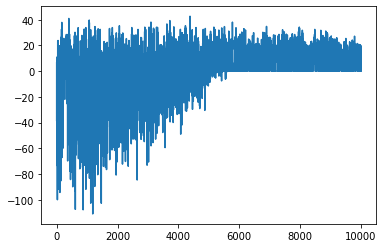

In [30]:
flatten = lambda l: [item for sublist in l for item in sublist]

l2 = flatten( records['rewards'] )
l3 = [sum(ll) for ll in l2]

plt.figure()
plt.plot(l3)
# plt.plot(smooth(l2, 10))

In [11]:
torch.save(records, 'results/records2')

torch.save({'actor':seller_agent.actor.state_dict(),
           'actor_target':seller_agent.actor_target.state_dict(),
          'critic':seller_agent.critic.state_dict(),
          'critic_target':seller_agent.critic_target.state_dict()}, 'results/models2')

In [12]:
torch.save(seller_agent.memory, 'results/memory2')